In [10]:
import torch
#@title Load Python libraries

! pip install alpha_vantage -q

# pip install numpy
import numpy as np

# pip install torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# pip install matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# pip install alpha_vantage
from alpha_vantage.timeseries import TimeSeries

!pip install unicodecsv
!pip install dtw-python 
!pip install similaritymeasures
!pip install pmdarima

import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from m4_data import *
import six
import sys
sys.modules['sklearn.externals.six'] = six
import joblib
sys.modules['sklearn.externals.joblib'] = joblib
import pmdarima as pm
import statsmodels.api as sm
import pandas as pd
from sklearn.metrics import mean_squared_error
import similaritymeasures
from IPython.display import clear_output
import time

print("All libraries loaded")

All libraries loaded


In [3]:
# Configuration
np.random.seed(0)
torch.manual_seed(0)
config = {
    "data": {
        "window_size": 1,
        "train_split_size": 0.88,
    }, 
    "plots": {
        "show_plots": True,
        "xticks_interval": 90,
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, # since we are only using 1 feature
        "num_lstm_layers": 1,
        "lstm_size": 12,
        "dropout": 0.2,
    },
    "training": {
        "device": "cpu", # "cuda" or "cpu"
        "batch_size": 1,
        "num_epoch": 100,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    }
}

In [4]:
# Detection Component

def detect(LNG_FOR, model_pmd=None, all_input_=[], detection_threshold=-1, corrected=False, auto_arima=False):
      
    if model_pmd is not None:
        
        print("Testing Correction at Cell states index: ", (len(all_input_)-LNG_FOR))
        
        SARIMAX_forecast = model_pmd[len(all_input_)-LNG_FOR :]
        # Creating an index from 2018-10-29 to Forecast Length, frequency indicates business day then putting it all together into a SARIMAX_forecast dataframe
        idx = pd.DatetimeIndex(pd.date_range('2018-10-29', periods=LNG_FOR, freq="B").tolist())

        SARIMAX_forecast = pd.DataFrame(list(zip(list(idx),list(SARIMAX_forecast))),
        columns=['Date','Forecast']).set_index('Date')

        meansq = mean_squared_error(all_input_[len(all_input_)-LNG_FOR:], 
          SARIMAX_forecast['Forecast'])

        #print("\tMean Squared Error - SARIMA:", meansq)
        rootmsq = np.sqrt(mean_squared_error(all_input_[len(all_input_)-LNG_FOR:], 
          SARIMAX_forecast['Forecast']))

        #print("\tRoot Mean Squared Error - SARIMA:", rootmsq)
        # Generate random experimental data
        all_input_ =list([0 for x in range((LNG_FOR*3))]) + list(all_input_)
        
        exp_data = np.zeros((LNG_FOR, 2))
        exp_data[:, 0] = list(range(len(all_input_), LNG_FOR + len(all_input_))) 
        exp_data[:, 1] = SARIMAX_forecast['Forecast'][len(SARIMAX_forecast['Forecast'])-LNG_FOR:]

        # Generate random numerical data

        num_data = np.zeros((LNG_FOR, 2))
        num_data[:, 0] = list(range(len(all_input_), LNG_FOR + len(all_input_))) 
        num_data[:, 1] = all_input_[len(all_input_)-LNG_FOR:]

        #plt.figure(figsize=(7, 3))
        #plt.plot(exp_data[:, 0], exp_data[:, 1], label="SARIMA", color="red")
        #plt.plot(num_data[:, 0], num_data[:, 1], label="LSTM cell state", color="black")
        #plt.legend()
        #plt.show()

        # quantify the difference between the two curves using
        # Dynamic Time Warping distance
        dtw_, d = similaritymeasures.dtw(exp_data, num_data)
        ret_empty =[]
    
        return [dtw_]
    else: 
        if auto_arima:
            print("Auto arima is finding best orders")
            print("Length of cell states is:", len(all_input_))
            model_pmd = pm.auto_arima(all_input_, 
                                  max_p=3, max_q=3, m=LNG_FOR,
                              start_P=0, 
                              d=0, D=1, 
                                  seasonal=True,
                                  trace=True)
            print('ARIMA lunched')        
            #Fitting the SARIMA model
            order_arima = model_pmd.order
            order_sarima = model_pmd.seasonal_order
        else:
            print("Finding distance with default SARIMA orders")
            print("Length of cell states is:", len(all_input_))
            order_arima = (1, 0, 1)
            order_sarima = (2, 1, 2, 12)
            
        print("Order sarima", order_sarima)
        
        #Instantiating the model using SARIMAX
        model = sm.tsa.statespace.SARIMAX(all_input_,

          order=order_arima,
          seasonal_order=order_sarima,
          enforce_stationarity=True,
          initialization='approximate_diffuse',
          enforce_invertibility=False)

        # Fitting the SARIMA model
        SARIMAX_results = model.fit(disp=False)
        
        pd_ar= SARIMAX_results.predict( start= 0, end= len(all_input_)-1 )
        
        detect_error = []

        for i in range(int(len(pd_ar)/LNG_FOR)):
            
            exp_data = np.zeros((LNG_FOR, 2))
            exp_data[:, 0] = list(range(0, LNG_FOR)) 
            exp_data[:, 1] = pd_ar[i*LNG_FOR : (i+1)*LNG_FOR]

            # Generate random numerical data
            num_data = np.zeros((LNG_FOR, 2))
            num_data[:, 0] = list(range(0, LNG_FOR))
            num_data[:, 1] = all_input_[i*LNG_FOR : (i+1)*LNG_FOR]
            dtw_, d = similaritymeasures.dtw(exp_data, num_data)

            if dtw_ > detection_threshold:
                detect_error = np.concatenate((detect_error, [i]))
            else:
                detect_error = np.concatenate((detect_error, [0])) 
        
        print(f"cLSTM will change {sum(detect_error != 0)} data points")
        return pd_ar, detect_error    

In [5]:
# Data Preparation
def prepare_data_x(x, window_size):
    # perform windowing
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row,window_size), strides=(x.strides[0],x.strides[0]))
    return output[:-1], output[-1]

def prepare_data_y(x, window_size):
    
    # perform simple moving average
    # output = np.convolve(x, np.ones(window_size), 'valid') / window_size
    # use the next day as label
    
    output = x[window_size:]
    return output

def prepare_data(normalized_data_close_price, config, plot=False):
    data_x, data_x_unseen = prepare_data_x(normalized_data_close_price, window_size=config["data"]["window_size"])
    data_y = prepare_data_y(normalized_data_close_price, window_size=config["data"]["window_size"])

    # split dataset

    split_index = int(data_y.shape[0]*config["data"]["train_split_size"])
    data_x_train = data_x[:split_index]
    data_x_val = data_x[split_index:]
    
    data_y_train = data_y[:split_index]
    data_y_val = data_y[split_index:]


    return split_index, data_x_train, data_y_train, data_x_val, data_y_val, data_x_unseen

class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        x = np.expand_dims(x, 2) # in our case, we have only 1 feature, so we need to convert `x` into [batch, sequence, features] for LSTM
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

class Normalizer():
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        self.mu = np.mean(x, axis=(0), keepdims=True)
        self.sd = np.std(x, axis=(0), keepdims=True)
        normalized_x = (x - self.mu)/self.sd
        return normalized_x

    def inverse_transform(self, x):
        return (x*self.sd) + self.mu

In [6]:
# LSTM
class LSTMModel(nn.Module):

        def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
            super().__init__()
            self.hidden_layer_size = hidden_layer_size
            self.linear_1 = nn.Linear(input_size, hidden_layer_size)
            self.relu = nn.ReLU()
            self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
            self.dropout = nn.Dropout(dropout)
            self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
            self.init_weights()
            self.historycorrectorlstm = []
            self.historycorrection = []
      
        def init_weights(self):
            for name, param in self.lstm.named_parameters():
                if 'bias' in name:
                    nn.init.constant_(param, 0.0)
                elif 'weight_ih' in name:
                    nn.init.kaiming_normal_(param)
                elif 'weight_hh' in name:
                    nn.init.orthogonal_(param)
        def forward(self, x):
            batchsize = x.shape[0]
            # layer 1
            x = self.linear_1(x)
            x = self.relu(x)

            # LSTM layer
            lstm_out, (h_n, c_n) = self.lstm(x)     

            # reshape output from hidden cell into [batch, features] for `linear_2`
            x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 

            # layer 2
            x = self.dropout(x)
            predictions = self.linear_2(x)
            return predictions[:,-1]

In [39]:
# Corrector LSTM
class cLSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)

        self.init_weights()
        self.historycorrectorlstm = []
        self.historycorrection = []
        self.historycorrectorlstm_archive = []
        
    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
    
    def forward(self, x, model_sarima=0, epoch_ready=False, pre_epoch=False, pre_pre_epoch=False, corrected=False, detection_threshold=0.8, repeat_sarima=False, auto_arima=False, run_detection=False ):
        
        if repeat_sarima:
            
            hidden_id = len(self.historycorrectorlstm) - 1 
            self.historycorrectorlstm_archive[hidden_id] = self.historycorrectorlstm[hidden_id]
            all_input_ = np.concatenate( self.historycorrectorlstm_archive, axis=0 )            
            pd_ar, detect_error = detect(12, 
                                             model_pmd =  None, 
                                             all_input_= all_input_, 
                                             detection_threshold= detection_threshold, 
                                             corrected=True, 
                                             auto_arima=auto_arima)
            
            
            return pd_ar, detect_error
        else:
            batchsize = x.shape[0]
            # layer 1
            value_best = x[0][0][0]
            x = self.linear_1(x)
            x = self.relu(x)

            # LSTM layer
            lstm_out, (h_n, c_n) = self.lstm(x)
            
            return_model = False
            all_input_ = []

            if pre_epoch:
                
                self.historycorrectorlstm.append(lstm_out.detach().numpy()[0][0])
                all_input_ = np.concatenate( self.historycorrectorlstm, axis=0 )

            if run_detection == True:     
                
                pd_ar, detect_error = detect(12, 
                                             model_pmd =  model_sarima, 
                                             all_input_= all_input_, 
                                             detection_threshold= detection_threshold, 
                                             corrected=True, 
                                             auto_arima=auto_arima)
                
                self.historycorrectorlstm_archive = self.historycorrectorlstm
                self.historycorrectorlstm = []            

            if epoch_ready:
                print("Len of all_input:" , len(all_input_))
                if corrected:
                    self.historycorrectorlstm = self.historycorrectorlstm[:-1] 
                    self.historycorrectorlstm.append(lstm_out.detach().numpy()[0][0])
                    all_input_ = np.concatenate( self.historycorrectorlstm, axis=0 )
                else:
                    self.historycorrectorlstm.append(lstm_out.detach().numpy()[0][0])
                    all_input_ = np.concatenate( self.historycorrectorlstm, axis=0 )

                if corrected == False:
                    self.historycorrection = []

                print("Length of cell states: ", len( all_input_ ))
                if corrected:
                    print("Corrected")
                    results_correction = detect(12, 
                                             model_pmd =  model_sarima, 
                                             all_input_= all_input_, 
                                             detection_threshold= detection_threshold, 
                                             corrected=True, 
                                             auto_arima=auto_arima)
                else:
                    print("No correction")                    
                    results_correction = detect(12, 
                                             model_pmd =  model_sarima, 
                                             all_input_= all_input_, 
                                             detection_threshold= detection_threshold, 
                                             corrected=False, 
                                             auto_arima=auto_arima)

                if (results_correction is not None):                    
                    self.historycorrection.append(results_correction)

            # reshape output from hidden cell into [batch, features] for `linear_2`
            x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 

            # layer 2
            x = self.dropout(x)
            predictions = self.linear_2(x)

            if run_detection:
                return predictions[:,-1], all_input_, self.historycorrectorlstm_archive, self.historycorrection, pd_ar, detect_error
            else:
                return predictions[:,-1], all_input_, self.historycorrection

In [40]:
detection_threshold = 0.6
correction_threshold = 0.2
use_auto_arima = False # find orders of ARIMA using auto.arima

Location: ./NAB-master/data\realTweets\Twitter_volume_IBM.csv
File Name: Twitter_volume_IBM.csv
Working on:  realTweets  series : Twitter_volume_IBM.csv


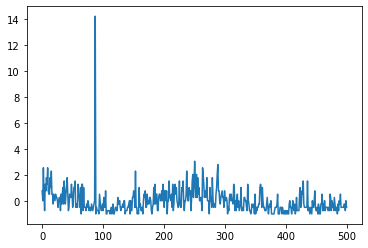

Train data shape (439, 1, 1) (439,)
Validation data shape (60, 1, 1) (60,)
Epoch[1/100] | loss train:435.100221, test:11.840335 | lr:0.010000
Epoch[2/100] | loss train:441.582506, test:13.646973 | lr:0.010000
Epoch[3/100] | loss train:438.733808, test:12.498091 | lr:0.010000
Epoch[4/100] | loss train:438.908457, test:13.071837 | lr:0.010000
Epoch[5/100] | loss train:435.805988, test:12.858236 | lr:0.010000
Epoch[6/100] | loss train:434.179117, test:13.340966 | lr:0.010000
Epoch[7/100] | loss train:432.619164, test:13.413309 | lr:0.010000
Epoch[8/100] | loss train:436.052970, test:13.960443 | lr:0.010000
Epoch[9/100] | loss train:439.467433, test:14.603334 | lr:0.010000
Epoch[10/100] | loss train:432.946669, test:13.727716 | lr:0.010000
Epoch[11/100] | loss train:441.458737, test:14.795720 | lr:0.010000
Epoch[12/100] | loss train:438.099042, test:14.620602 | lr:0.010000
Epoch[13/100] | loss train:431.296520, test:13.192107 | lr:0.010000
Epoch[14/100] | loss train:435.642765, test:14.407

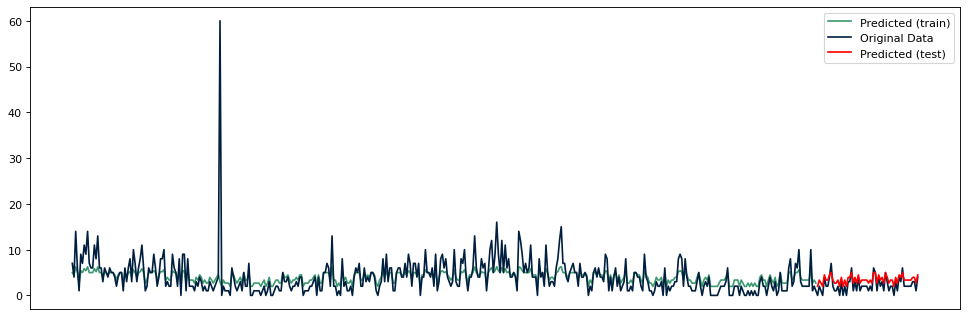

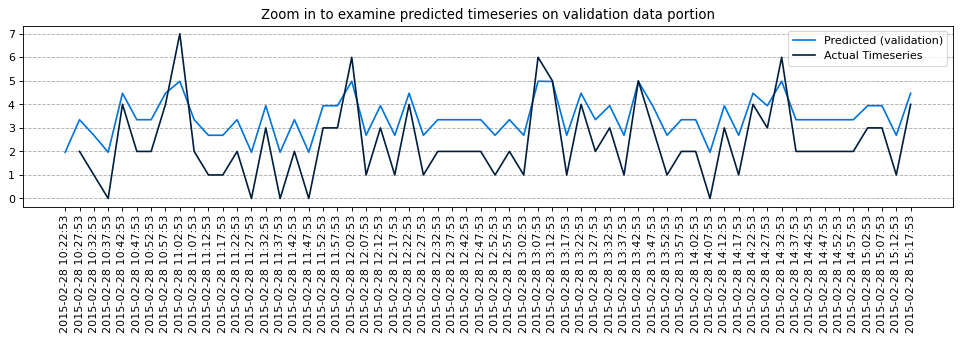

LSTM RMSE --  1.3540998728929288
Location: ./NAB-master/data\realTweets\Twitter_volume_IBM.csv
File Name: Twitter_volume_IBM.csv
Working on:  realTweets  series : Twitter_volume_IBM.csv


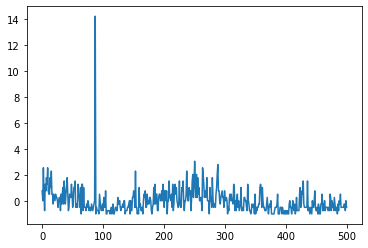

Train data shape (439, 1, 1) (439,)
Validation data shape (60, 1, 1) (60,)
Epoch[1/100] | loss train:435.100221 | lr:0.010000
Epoch[2/100] | loss train:440.717863 | lr:0.010000
Epoch[3/100] | loss train:432.387968 | lr:0.010000
Epoch[4/100] | loss train:438.263004 | lr:0.010000
Epoch[5/100] | loss train:434.898365 | lr:0.010000
Epoch[6/100] | loss train:432.149323 | lr:0.010000
Epoch[7/100] | loss train:433.007583 | lr:0.010000
Epoch[8/100] | loss train:434.269367 | lr:0.010000
Epoch[9/100] | loss train:436.732614 | lr:0.010000
Epoch[10/100] | loss train:435.010099 | lr:0.010000
Epoch[11/100] | loss train:432.990362 | lr:0.010000
Epoch[12/100] | loss train:434.321980 | lr:0.010000
Epoch[13/100] | loss train:428.858765 | lr:0.010000
Epoch[14/100] | loss train:430.642582 | lr:0.010000
Epoch[15/100] | loss train:435.314069 | lr:0.010000
Epoch[16/100] | loss train:435.966156 | lr:0.010000
Epoch[17/100] | loss train:438.219991 | lr:0.010000
Epoch[18/100] | loss train:436.448007 | lr:0.01000

C:\Users\LSTM\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


cLSTM will change 251 data points
Epoch[49/100] | loss train:432.697385 | lr:0.001000
Epoch ready - ID:  0
Raw time series value:  tensor(0.7902)
Len of all_input: 0
Length of cell states:  12
No correction
[ 0.          0.0007988  -0.00331098 ... -0.62702597  0.39759529
 -0.07233228]
Testing Correction at Cell states index:  0
	Mean Squared Error - SARIMA: 0.0018013871654878023
Initial value: tensor(0.7902)
Epoch ready - ID:  1
Raw time series value:  tensor(0.0309)
Len of all_input: 0
Length of cell states:  24
No correction
[ 0.          0.0007988  -0.00331098 ... -0.62702597  0.39759529
 -0.07233228]
Testing Correction at Cell states index:  12
	Mean Squared Error - SARIMA: 0.01571538089944673
Initial value: tensor(0.0309)
Epoch ready - ID:  2
Raw time series value:  tensor(2.5618)
Len of all_input: 0
Length of cell states:  36
No correction
[ 0.          0.0007988  -0.00331098 ... -0.62702597  0.39759529
 -0.07233228]
Testing Correction at Cell states index:  24
	Mean Squared Erro

	Mean Squared Error - SARIMA: 0.03530856319319157
Len of all_input: 0
Length of cell states:  60
Corrected
Testing Correction at Cell states index:  48
	Mean Squared Error - SARIMA: 0.034524303972886576
Len of all_input: 0
Length of cell states:  60
Corrected
Testing Correction at Cell states index:  48
	Mean Squared Error - SARIMA: 0.03376280044449374
Len of all_input: 0
Length of cell states:  60
Corrected
Testing Correction at Cell states index:  48
	Mean Squared Error - SARIMA: 0.033023442361061306
Len of all_input: 0
Length of cell states:  60
Corrected
Testing Correction at Cell states index:  48
	Mean Squared Error - SARIMA: 0.032305504119175675
Len of all_input: 0
Length of cell states:  60
Corrected
Testing Correction at Cell states index:  48
	Mean Squared Error - SARIMA: 0.0316081872256962
Len of all_input: 0
Length of cell states:  60
Corrected
Testing Correction at Cell states index:  48
	Mean Squared Error - SARIMA: 0.0309306194643407
Len of all_input: 0
Length of cell st

	Mean Squared Error - SARIMA: 0.019672770508603884
Initial value: tensor(1.2964)
Len of all_input: 0
Length of cell states:  72
Corrected
Testing Correction at Cell states index:  60
	Mean Squared Error - SARIMA: 0.019672770508603884
Len of all_input: 0
Length of cell states:  72
Corrected
Testing Correction at Cell states index:  60
	Mean Squared Error - SARIMA: 0.01913679158014717
Len of all_input: 0
Length of cell states:  72
Corrected
Testing Correction at Cell states index:  60
	Mean Squared Error - SARIMA: 0.018574671583162516
Len of all_input: 0
Length of cell states:  72
Corrected
Testing Correction at Cell states index:  60
	Mean Squared Error - SARIMA: 0.01796018580376273
Len of all_input: 0
Length of cell states:  72
Corrected
Testing Correction at Cell states index:  60
	Mean Squared Error - SARIMA: 0.018574671583162516
Len of all_input: 0
Length of cell states:  72
Corrected
Testing Correction at Cell states index:  60
	Mean Squared Error - SARIMA: 0.01913679158014717
Len 

Raw time series value:  tensor(2.3087)
Len of all_input: 0
Length of cell states:  192
No correction
[ 0.          0.0007988  -0.00331098 ... -0.62702597  0.39759529
 -0.07233228]
Testing Correction at Cell states index:  180
	Mean Squared Error - SARIMA: 0.016827054935135876
Initial value: tensor(2.3087)
Len of all_input: 0
Length of cell states:  192
Corrected
Testing Correction at Cell states index:  180
	Mean Squared Error - SARIMA: 0.016827054935135876
Len of all_input: 0
Length of cell states:  192
Corrected
Testing Correction at Cell states index:  180
	Mean Squared Error - SARIMA: 0.01386025376805398
Len of all_input: 0
Length of cell states:  192
Corrected
Testing Correction at Cell states index:  180
	Mean Squared Error - SARIMA: 0.011139273464359308
Len of all_input: 0
Length of cell states:  192
Corrected
Testing Correction at Cell states index:  180
	Mean Squared Error - SARIMA: 0.008760919328462222
Len of all_input: 0
Length of cell states:  192
Corrected
Testing Correcti

Len of all_input: 0
Length of cell states:  228
Corrected
Testing Correction at Cell states index:  216
	Mean Squared Error - SARIMA: 0.005267751699356623
Len of all_input: 0
Length of cell states:  228
Corrected
Testing Correction at Cell states index:  216
	Mean Squared Error - SARIMA: 0.004979347850561256
Len of all_input: 0
Length of cell states:  228
Corrected
Testing Correction at Cell states index:  216
	Mean Squared Error - SARIMA: 0.004721638032671559
Len of all_input: 0
Length of cell states:  228
Corrected
Testing Correction at Cell states index:  216
	Mean Squared Error - SARIMA: 0.004492140797246149
Len of all_input: 0
Length of cell states:  228
Corrected
Testing Correction at Cell states index:  216
	Mean Squared Error - SARIMA: 0.004455114363627337
Len of all_input: 0
Length of cell states:  228
Corrected
Testing Correction at Cell states index:  216
	Mean Squared Error - SARIMA: 0.004423193287126076
Len of all_input: 0
Length of cell states:  228
Corrected
Testing Corr

Epoch ready - ID:  26
Raw time series value:  tensor(-0.4753)
Len of all_input: 0
Length of cell states:  324
No correction
[ 0.          0.0007988  -0.00331098 ... -0.62702597  0.39759529
 -0.07233228]
Testing Correction at Cell states index:  312
	Mean Squared Error - SARIMA: 0.034914576230205566
Initial value: tensor(-0.4753)
Len of all_input: 0
Length of cell states:  324
Corrected
Testing Correction at Cell states index:  312
	Mean Squared Error - SARIMA: 0.034914576230205566
Len of all_input: 0
Length of cell states:  324
Corrected
Testing Correction at Cell states index:  312
	Mean Squared Error - SARIMA: 0.04580778979670975
Len of all_input: 0
Length of cell states:  324
Corrected
Testing Correction at Cell states index:  312
	Mean Squared Error - SARIMA: 0.034914580578497285
Len of all_input: 0
Length of cell states:  324
Corrected
Testing Correction at Cell states index:  312
	Mean Squared Error - SARIMA: 0.026403219182671803
Len of all_input: 0
Length of cell states:  324
Co

Len of all_input: 0
Length of cell states:  372
Corrected
Testing Correction at Cell states index:  360
	Mean Squared Error - SARIMA: 0.022559582456820753
Len of all_input: 0
Length of cell states:  372
Corrected
Testing Correction at Cell states index:  360
	Mean Squared Error - SARIMA: 0.022021130596946225
Len of all_input: 0
Length of cell states:  372
Corrected
Testing Correction at Cell states index:  360
	Mean Squared Error - SARIMA: 0.02149921393047745
Len of all_input: 0
Length of cell states:  372
Corrected
Testing Correction at Cell states index:  360
	Mean Squared Error - SARIMA: 0.020992757952098706
Len of all_input: 0
Length of cell states:  372
Corrected
Testing Correction at Cell states index:  360
	Mean Squared Error - SARIMA: 0.020500585320789105
Len of all_input: 0
Length of cell states:  372
Corrected
Testing Correction at Cell states index:  360
	Mean Squared Error - SARIMA: 0.02002153015496534
Len of all_input: 0
Length of cell states:  372
Corrected
Testing Correc

Len of all_input: 0
Length of cell states:  396
Corrected
Testing Correction at Cell states index:  384
	Mean Squared Error - SARIMA: 0.007576166859112034
Len of all_input: 0
Length of cell states:  396
Corrected
Testing Correction at Cell states index:  384
	Mean Squared Error - SARIMA: 0.003699609874053445
Len of all_input: 0
Length of cell states:  396
Corrected
Testing Correction at Cell states index:  384
	Mean Squared Error - SARIMA: 0.002531979820966007
Len of all_input: 0
Length of cell states:  396
Corrected
Testing Correction at Cell states index:  384
	Mean Squared Error - SARIMA: 0.0030020825232754994
Len of all_input: 0
Length of cell states:  396
Corrected
Testing Correction at Cell states index:  384
	Mean Squared Error - SARIMA: 0.002531979820966007
Len of all_input: 0
Length of cell states:  396
Corrected
Testing Correction at Cell states index:  384
	Mean Squared Error - SARIMA: 0.003699609874053445
Len of all_input: 0
Length of cell states:  396
Corrected
Testing Cor

Length of cell states:  468
Corrected
Testing Correction at Cell states index:  456
	Mean Squared Error - SARIMA: 0.0034246320248938924
Len of all_input: 0
Length of cell states:  468
Corrected
Testing Correction at Cell states index:  456
	Mean Squared Error - SARIMA: 0.002549794778029277
Len of all_input: 0
Length of cell states:  468
Corrected
Testing Correction at Cell states index:  456
	Mean Squared Error - SARIMA: 0.0031182392738596646
Len of all_input: 0
Length of cell states:  468
Corrected
Testing Correction at Cell states index:  456
	Mean Squared Error - SARIMA: 0.002549794778029277
Len of all_input: 0
Length of cell states:  468
Corrected
Testing Correction at Cell states index:  456
	Mean Squared Error - SARIMA: 0.0034246320248938924
Len of all_input: 0
Length of cell states:  468
Corrected
Testing Correction at Cell states index:  456
	Mean Squared Error - SARIMA: 0.002549794778029277
Len of all_input: 0
Length of cell states:  468
Corrected
Testing Correction at Cell st

Length of cell states:  528
Corrected
Testing Correction at Cell states index:  516
	Mean Squared Error - SARIMA: 0.03710890676473885
Len of all_input: 0
Length of cell states:  528
Corrected
Testing Correction at Cell states index:  516
	Mean Squared Error - SARIMA: 0.036179695964896605
Len of all_input: 0
Length of cell states:  528
Corrected
Testing Correction at Cell states index:  516
	Mean Squared Error - SARIMA: 0.03527457555874684
Len of all_input: 0
Length of cell states:  528
Corrected
Testing Correction at Cell states index:  516
	Mean Squared Error - SARIMA: 0.034393783649083375
Len of all_input: 0
Length of cell states:  528
Corrected
Testing Correction at Cell states index:  516
	Mean Squared Error - SARIMA: 0.0335374614112431
Len of all_input: 0
Length of cell states:  528
Corrected
Testing Correction at Cell states index:  516
	Mean Squared Error - SARIMA: 0.03270564495624984
Len of all_input: 0
Length of cell states:  528
Corrected
Testing Correction at Cell states ind

Len of all_input: 0
Length of cell states:  528
Corrected
Testing Correction at Cell states index:  516
	Mean Squared Error - SARIMA: 0.007519698022466108
Len of all_input: 0
Length of cell states:  528
Corrected
Testing Correction at Cell states index:  516
	Mean Squared Error - SARIMA: 0.007250909307908422
Len of all_input: 0
Length of cell states:  528
Corrected
Testing Correction at Cell states index:  516
	Mean Squared Error - SARIMA: 0.007011087513898748
Len of all_input: 0
Length of cell states:  528
Corrected
Testing Correction at Cell states index:  516
	Mean Squared Error - SARIMA: 0.006801822332418556
Len of all_input: 0
Length of cell states:  528
Corrected
Testing Correction at Cell states index:  516
	Mean Squared Error - SARIMA: 0.0066244179107480565
Len of all_input: 0
Length of cell states:  528
Corrected
Testing Correction at Cell states index:  516
	Mean Squared Error - SARIMA: 0.006479851156513178
Len of all_input: 0
Length of cell states:  528
Corrected
Testing Cor

Len of all_input: 0
Length of cell states:  588
Corrected
Testing Correction at Cell states index:  576
	Mean Squared Error - SARIMA: 0.0028315938206748656
Len of all_input: 0
Length of cell states:  588
Corrected
Testing Correction at Cell states index:  576
	Mean Squared Error - SARIMA: 0.0023758027850020002
Len of all_input: 0
Length of cell states:  588
Corrected
Testing Correction at Cell states index:  576
	Mean Squared Error - SARIMA: 0.0019450179498668348
Len of all_input: 0
Length of cell states:  588
Corrected
Testing Correction at Cell states index:  576
	Mean Squared Error - SARIMA: 0.0015542458092560798
Len of all_input: 0
Length of cell states:  588
Corrected
Testing Correction at Cell states index:  576
	Mean Squared Error - SARIMA: 0.0011058149023274737
Len of all_input: 0
Length of cell states:  588
Corrected
Testing Correction at Cell states index:  576
	Mean Squared Error - SARIMA: 0.0012761568871540892
Len of all_input: 0
Length of cell states:  588
Corrected
Testin

	Mean Squared Error - SARIMA: 0.03542532064506514
Initial value: tensor(-0.4753)
Len of all_input: 0
Length of cell states:  672
Corrected
Testing Correction at Cell states index:  660
	Mean Squared Error - SARIMA: 0.03542532064506514
Len of all_input: 0
Length of cell states:  672
Corrected
Testing Correction at Cell states index:  660
	Mean Squared Error - SARIMA: 0.04512841356438738
Len of all_input: 0
Length of cell states:  672
Corrected
Testing Correction at Cell states index:  660
	Mean Squared Error - SARIMA: 0.03542532179096387
Len of all_input: 0
Length of cell states:  672
Corrected
Testing Correction at Cell states index:  660
	Mean Squared Error - SARIMA: 0.028057466533842366
Len of all_input: 0
Length of cell states:  672
Corrected
Testing Correction at Cell states index:  660
	Mean Squared Error - SARIMA: 0.022650731570499807
Len of all_input: 0
Length of cell states:  672
Corrected
Testing Correction at Cell states index:  660
	Mean Squared Error - SARIMA: 0.01811212639

Testing Correction at Cell states index:  696
	Mean Squared Error - SARIMA: 0.00705400615246142
Len of all_input: 0
Length of cell states:  708
Corrected
Testing Correction at Cell states index:  696
	Mean Squared Error - SARIMA: 0.005831694630255242
Len of all_input: 0
Length of cell states:  708
Corrected
Testing Correction at Cell states index:  696
	Mean Squared Error - SARIMA: 0.005102928673296935
Len of all_input: 0
Length of cell states:  708
Corrected
Testing Correction at Cell states index:  696
	Mean Squared Error - SARIMA: 0.005831694630255242
Len of all_input: 0
Length of cell states:  708
Corrected
Testing Correction at Cell states index:  696
	Mean Squared Error - SARIMA: 0.00705400615246142
Len of all_input: 0
Length of cell states:  708
Corrected
Testing Correction at Cell states index:  696
	Mean Squared Error - SARIMA: 0.005831694630255242
Len of all_input: 0
Length of cell states:  708
Corrected
Testing Correction at Cell states index:  696
	Mean Squared Error - SARI

Len of all_input: 0
Length of cell states:  780
Corrected
Testing Correction at Cell states index:  768
	Mean Squared Error - SARIMA: 0.05462635024813305
Len of all_input: 0
Length of cell states:  780
Corrected
Testing Correction at Cell states index:  768
	Mean Squared Error - SARIMA: 0.047041372701932545
Len of all_input: 0
Length of cell states:  780
Corrected
Testing Correction at Cell states index:  768
	Mean Squared Error - SARIMA: 0.036663501228966285
Len of all_input: 0
Length of cell states:  780
Corrected
Testing Correction at Cell states index:  768
	Mean Squared Error - SARIMA: 0.028204775894854414
Len of all_input: 0
Length of cell states:  780
Corrected
Testing Correction at Cell states index:  768
	Mean Squared Error - SARIMA: 0.022145811187221993
Len of all_input: 0
Length of cell states:  780
Corrected
Testing Correction at Cell states index:  768
	Mean Squared Error - SARIMA: 0.018131789952165165
Len of all_input: 0
Length of cell states:  780
Corrected
Testing Corre

Len of all_input: 0
Length of cell states:  816
Corrected
Testing Correction at Cell states index:  804
	Mean Squared Error - SARIMA: 0.0405277105674797
Len of all_input: 0
Length of cell states:  816
Corrected
Testing Correction at Cell states index:  804
	Mean Squared Error - SARIMA: 0.0395083215437971
Len of all_input: 0
Length of cell states:  816
Corrected
Testing Correction at Cell states index:  804
	Mean Squared Error - SARIMA: 0.03850398609610166
Len of all_input: 0
Length of cell states:  816
Corrected
Testing Correction at Cell states index:  804
	Mean Squared Error - SARIMA: 0.037515633655728645
Len of all_input: 0
Length of cell states:  816
Corrected
Testing Correction at Cell states index:  804
	Mean Squared Error - SARIMA: 0.03654417480658803
Len of all_input: 0
Length of cell states:  816
Corrected
Testing Correction at Cell states index:  804
	Mean Squared Error - SARIMA: 0.03559047374526709
Len of all_input: 0
Length of cell states:  816
Corrected
Testing Correction 

Len of all_input: 0
Length of cell states:  840
Corrected
Testing Correction at Cell states index:  828
	Mean Squared Error - SARIMA: 0.016840702435403945
Len of all_input: 0
Length of cell states:  840
Corrected
Testing Correction at Cell states index:  828
	Mean Squared Error - SARIMA: 0.013914789733100917
Len of all_input: 0
Length of cell states:  840
Corrected
Testing Correction at Cell states index:  828
	Mean Squared Error - SARIMA: 0.010709186992766767
Len of all_input: 0
Length of cell states:  840
Corrected
Testing Correction at Cell states index:  828
	Mean Squared Error - SARIMA: 0.013914789733100917
Len of all_input: 0
Length of cell states:  840
Corrected
Testing Correction at Cell states index:  828
	Mean Squared Error - SARIMA: 0.016840702435403945
Len of all_input: 0
Length of cell states:  840
Corrected
Testing Correction at Cell states index:  828
	Mean Squared Error - SARIMA: 0.013914789733100917
Len of all_input: 0
Length of cell states:  840
Corrected
Testing Corr

Len of all_input: 0
Length of cell states:  876
Corrected
Testing Correction at Cell states index:  864
	Mean Squared Error - SARIMA: 0.005758219482545057
Len of all_input: 0
Length of cell states:  876
Corrected
Testing Correction at Cell states index:  864
	Mean Squared Error - SARIMA: 0.005662611444266752
Len of all_input: 0
Length of cell states:  876
Corrected
Testing Correction at Cell states index:  864
	Mean Squared Error - SARIMA: 0.005586037761510343
Len of all_input: 0
Length of cell states:  876
Corrected
Testing Correction at Cell states index:  864
	Mean Squared Error - SARIMA: 0.005527538536619278
Len of all_input: 0
Length of cell states:  876
Corrected
Testing Correction at Cell states index:  864
	Mean Squared Error - SARIMA: 0.0054861128135843444
Len of all_input: 0
Length of cell states:  876
Corrected
Testing Correction at Cell states index:  864
	Mean Squared Error - SARIMA: 0.005527538536619278
Len of all_input: 0
Length of cell states:  876
Corrected
Testing Cor

	Mean Squared Error - SARIMA: 0.01416439783829724
Len of all_input: 0
Length of cell states:  936
Corrected
Testing Correction at Cell states index:  924
	Mean Squared Error - SARIMA: 0.01343841847297999
Len of all_input: 0
Length of cell states:  936
Corrected
Testing Correction at Cell states index:  924
	Mean Squared Error - SARIMA: 0.012734509098530735
Len of all_input: 0
Length of cell states:  936
Corrected
Testing Correction at Cell states index:  924
	Mean Squared Error - SARIMA: 0.01205338274374533
Len of all_input: 0
Length of cell states:  936
Corrected
Testing Correction at Cell states index:  924
	Mean Squared Error - SARIMA: 0.011395679501094491
Len of all_input: 0
Length of cell states:  936
Corrected
Testing Correction at Cell states index:  924
	Mean Squared Error - SARIMA: 0.010762013402776771
Len of all_input: 0
Length of cell states:  936
Corrected
Testing Correction at Cell states index:  924
	Mean Squared Error - SARIMA: 0.010152923112368513
Len of all_input: 0
Le

Len of all_input: 0
Length of cell states:  960
Corrected
Testing Correction at Cell states index:  948
	Mean Squared Error - SARIMA: 0.002509157101566906
Len of all_input: 0
Length of cell states:  960
Corrected
Testing Correction at Cell states index:  948
	Mean Squared Error - SARIMA: 0.0024389221306047753
Len of all_input: 0
Length of cell states:  960
Corrected
Testing Correction at Cell states index:  948
	Mean Squared Error - SARIMA: 0.002391742385749535
Len of all_input: 0
Length of cell states:  960
Corrected
Testing Correction at Cell states index:  948
	Mean Squared Error - SARIMA: 0.0023669111177260505
Len of all_input: 0
Length of cell states:  960
Corrected
Testing Correction at Cell states index:  948
	Mean Squared Error - SARIMA: 0.0023636615028663015
Len of all_input: 0
Length of cell states:  960
Corrected
Testing Correction at Cell states index:  948
	Mean Squared Error - SARIMA: 0.0023669111177260505
Len of all_input: 0
Length of cell states:  960
Corrected
Testing 

Len of all_input: 0
Length of cell states:  1008
Corrected
Testing Correction at Cell states index:  996
	Mean Squared Error - SARIMA: 0.009431993105517891
Len of all_input: 0
Length of cell states:  1008
Corrected
Testing Correction at Cell states index:  996
	Mean Squared Error - SARIMA: 0.00882442931247073
Len of all_input: 0
Length of cell states:  1008
Corrected
Testing Correction at Cell states index:  996
	Mean Squared Error - SARIMA: 0.00823591630507657
Len of all_input: 0
Length of cell states:  1008
Corrected
Testing Correction at Cell states index:  996
	Mean Squared Error - SARIMA: 0.007667294810902629
Len of all_input: 0
Length of cell states:  1008
Corrected
Testing Correction at Cell states index:  996
	Mean Squared Error - SARIMA: 0.007119359002462161
Len of all_input: 0
Length of cell states:  1008
Corrected
Testing Correction at Cell states index:  996
	Mean Squared Error - SARIMA: 0.006592880430623946
Len of all_input: 0
Length of cell states:  1008
Corrected
Testing

Testing Correction at Cell states index:  1044
	Mean Squared Error - SARIMA: 0.11864398966966717
Len of all_input: 0
Length of cell states:  1056
Corrected
Testing Correction at Cell states index:  1044
	Mean Squared Error - SARIMA: 0.11863014662674592
Len of all_input: 0
Length of cell states:  1056
Corrected
Testing Correction at Cell states index:  1044
	Mean Squared Error - SARIMA: 0.11861489947487837
Len of all_input: 0
Length of cell states:  1056
Corrected
Testing Correction at Cell states index:  1044
	Mean Squared Error - SARIMA: 0.11859811676606263
Len of all_input: 0
Length of cell states:  1056
Corrected
Testing Correction at Cell states index:  1044
	Mean Squared Error - SARIMA: 0.11857963741267126
Len of all_input: 0
Length of cell states:  1056
Corrected
Testing Correction at Cell states index:  1044
	Mean Squared Error - SARIMA: 0.1185592849746173
Len of all_input: 0
Length of cell states:  1056
Corrected
Testing Correction at Cell states index:  1044
	Mean Squared Erro

	Mean Squared Error - SARIMA: 0.06127597424756729
Len of all_input: 0
Length of cell states:  1056
Corrected
Testing Correction at Cell states index:  1044
	Mean Squared Error - SARIMA: 0.061155958367426176
Len of all_input: 0
Length of cell states:  1056
Corrected
Testing Correction at Cell states index:  1044
	Mean Squared Error - SARIMA: 0.0610516751520169
Len of all_input: 0
Length of cell states:  1056
Corrected
Testing Correction at Cell states index:  1044
	Mean Squared Error - SARIMA: 0.061155958367426176
Len of all_input: 0
Length of cell states:  1056
Corrected
Testing Correction at Cell states index:  1044
	Mean Squared Error - SARIMA: 0.06127597424756729
Len of all_input: 0
Length of cell states:  1056
Corrected
Testing Correction at Cell states index:  1044
	Mean Squared Error - SARIMA: 0.061155958367426176
Len of all_input: 0
Length of cell states:  1056
Corrected
Testing Correction at Cell states index:  1044
	Mean Squared Error - SARIMA: 0.0610516751520169
Len of all_in

Len of all_input: 0
Length of cell states:  1068
Corrected
Testing Correction at Cell states index:  1056
	Mean Squared Error - SARIMA: 0.011637481625007497
Len of all_input: 0
Length of cell states:  1068
Corrected
Testing Correction at Cell states index:  1056
	Mean Squared Error - SARIMA: 0.011594933180701818
Len of all_input: 0
Length of cell states:  1068
Corrected
Testing Correction at Cell states index:  1056
	Mean Squared Error - SARIMA: 0.011637481625007497
Len of all_input: 0
Length of cell states:  1068
Corrected
Testing Correction at Cell states index:  1056
	Mean Squared Error - SARIMA: 0.01170115905887624
Len of all_input: 0
Length of cell states:  1068
Corrected
Testing Correction at Cell states index:  1056
	Mean Squared Error - SARIMA: 0.011637481625007497
Len of all_input: 0
Length of cell states:  1068
Corrected
Testing Correction at Cell states index:  1056
	Mean Squared Error - SARIMA: 0.011594933180701818
Len of all_input: 0
Length of cell states:  1068
Corrected


Len of all_input: 0
Length of cell states:  1104
Corrected
Testing Correction at Cell states index:  1092
	Mean Squared Error - SARIMA: 0.004425965694995935
Len of all_input: 0
Length of cell states:  1104
Corrected
Testing Correction at Cell states index:  1092
	Mean Squared Error - SARIMA: 0.004040650401377216
Len of all_input: 0
Length of cell states:  1104
Corrected
Testing Correction at Cell states index:  1092
	Mean Squared Error - SARIMA: 0.003678678453843983
Len of all_input: 0
Length of cell states:  1104
Corrected
Testing Correction at Cell states index:  1092
	Mean Squared Error - SARIMA: 0.003340679025224142
Len of all_input: 0
Length of cell states:  1104
Corrected
Testing Correction at Cell states index:  1092
	Mean Squared Error - SARIMA: 0.003027233893654092
Len of all_input: 0
Length of cell states:  1104
Corrected
Testing Correction at Cell states index:  1092
	Mean Squared Error - SARIMA: 0.002738875647269981
Len of all_input: 0
Length of cell states:  1104
Corrected

Len of all_input: 0
Length of cell states:  1128
Corrected
Testing Correction at Cell states index:  1116
	Mean Squared Error - SARIMA: 0.0012821981441576414
Len of all_input: 0
Length of cell states:  1128
Corrected
Testing Correction at Cell states index:  1116
	Mean Squared Error - SARIMA: 0.0012821981441576414
Epoch ready - ID:  94
Raw time series value:  tensor(0.5371)
Len of all_input: 0
Length of cell states:  1140
No correction
[ 0.          0.0007988  -0.00331098 ... -0.62702597  0.39759529
 -0.07233228]
Testing Correction at Cell states index:  1128
	Mean Squared Error - SARIMA: 0.04783161193466401
Initial value: tensor(0.5371)
Len of all_input: 0
Length of cell states:  1140
Corrected
Testing Correction at Cell states index:  1128
	Mean Squared Error - SARIMA: 0.04783161193466401
Len of all_input: 0
Length of cell states:  1140
Corrected
Testing Correction at Cell states index:  1128
	Mean Squared Error - SARIMA: 0.045938942158477
Len of all_input: 0
Length of cell states:  

Len of all_input: 0
Length of cell states:  1176
Corrected
Testing Correction at Cell states index:  1164
	Mean Squared Error - SARIMA: 0.004161632392574553
Len of all_input: 0
Length of cell states:  1176
Corrected
Testing Correction at Cell states index:  1164
	Mean Squared Error - SARIMA: 0.0037867376921009617
Len of all_input: 0
Length of cell states:  1176
Corrected
Testing Correction at Cell states index:  1164
	Mean Squared Error - SARIMA: 0.003436708602179015
Len of all_input: 0
Length of cell states:  1176
Corrected
Testing Correction at Cell states index:  1164
	Mean Squared Error - SARIMA: 0.0031120528183892437
Len of all_input: 0
Length of cell states:  1176
Corrected
Testing Correction at Cell states index:  1164
	Mean Squared Error - SARIMA: 0.0028132161822234537
Len of all_input: 0
Length of cell states:  1176
Corrected
Testing Correction at Cell states index:  1164
	Mean Squared Error - SARIMA: 0.0025405838010913485
Len of all_input: 0
Length of cell states:  1176
Corre

Testing Correction at Cell states index:  1200
	Mean Squared Error - SARIMA: 0.0013459434112873703
Len of all_input: 0
Length of cell states:  1212
Corrected
Testing Correction at Cell states index:  1200
	Mean Squared Error - SARIMA: 0.0013251544836099117
Len of all_input: 0
Length of cell states:  1212
Corrected
Testing Correction at Cell states index:  1200
	Mean Squared Error - SARIMA: 0.0013459434112873703
Len of all_input: 0
Length of cell states:  1212
Corrected
Testing Correction at Cell states index:  1200
	Mean Squared Error - SARIMA: 0.001392160959749547
Len of all_input: 0
Length of cell states:  1212
Corrected
Testing Correction at Cell states index:  1200
	Mean Squared Error - SARIMA: 0.0013459434112873703
Len of all_input: 0
Length of cell states:  1212
Corrected
Testing Correction at Cell states index:  1200
	Mean Squared Error - SARIMA: 0.0013251544836099117
Len of all_input: 0
Length of cell states:  1212
Corrected
Testing Correction at Cell states index:  1200
	Mean 

Len of all_input: 0
Length of cell states:  1272
Corrected
Testing Correction at Cell states index:  1260
	Mean Squared Error - SARIMA: 0.030793063540700587
Len of all_input: 0
Length of cell states:  1272
Corrected
Testing Correction at Cell states index:  1260
	Mean Squared Error - SARIMA: 0.03020615893769621
Len of all_input: 0
Length of cell states:  1272
Corrected
Testing Correction at Cell states index:  1260
	Mean Squared Error - SARIMA: 0.029621459237469134
Len of all_input: 0
Length of cell states:  1272
Corrected
Testing Correction at Cell states index:  1260
	Mean Squared Error - SARIMA: 0.029039149792705193
Len of all_input: 0
Length of cell states:  1272
Corrected
Testing Correction at Cell states index:  1260
	Mean Squared Error - SARIMA: 0.0284594251803706
Len of all_input: 0
Length of cell states:  1272
Corrected
Testing Correction at Cell states index:  1260
	Mean Squared Error - SARIMA: 0.027882537152675465
Len of all_input: 0
Length of cell states:  1272
Corrected
Te

	Mean Squared Error - SARIMA: 0.005220700490314593
Len of all_input: 0
Length of cell states:  1284
Corrected
Testing Correction at Cell states index:  1272
	Mean Squared Error - SARIMA: 0.002119685455320735
Len of all_input: 0
Length of cell states:  1284
Corrected
Testing Correction at Cell states index:  1272
	Mean Squared Error - SARIMA: 0.0015247752667730985
Len of all_input: 0
Length of cell states:  1284
Corrected
Testing Correction at Cell states index:  1272
	Mean Squared Error - SARIMA: 0.0035675811369193775
Len of all_input: 0
Length of cell states:  1284
Corrected
Testing Correction at Cell states index:  1272
	Mean Squared Error - SARIMA: 0.0015247752667730985
Len of all_input: 0
Length of cell states:  1284
Corrected
Testing Correction at Cell states index:  1272
	Mean Squared Error - SARIMA: 0.002119685455320735
Len of all_input: 0
Length of cell states:  1284
Corrected
Testing Correction at Cell states index:  1272
	Mean Squared Error - SARIMA: 0.0015247752667730985
Len

	Mean Squared Error - SARIMA: 0.0016620365927611234
Len of all_input: 0
Length of cell states:  1308
Corrected
Testing Correction at Cell states index:  1296
	Mean Squared Error - SARIMA: 0.0014858480568969658
Len of all_input: 0
Length of cell states:  1308
Corrected
Testing Correction at Cell states index:  1296
	Mean Squared Error - SARIMA: 0.0013357655157341813
Len of all_input: 0
Length of cell states:  1308
Corrected
Testing Correction at Cell states index:  1296
	Mean Squared Error - SARIMA: 0.0012121273521259607
Len of all_input: 0
Length of cell states:  1308
Corrected
Testing Correction at Cell states index:  1296
	Mean Squared Error - SARIMA: 0.0011152053581470877
Len of all_input: 0
Length of cell states:  1308
Corrected
Testing Correction at Cell states index:  1296
	Mean Squared Error - SARIMA: 0.0010452055659565904
Len of all_input: 0
Length of cell states:  1308
Corrected
Testing Correction at Cell states index:  1296
	Mean Squared Error - SARIMA: 0.001002266120534821
L

Len of all_input: 0
Length of cell states:  1344
Corrected
Testing Correction at Cell states index:  1332
	Mean Squared Error - SARIMA: 0.0008687864669587033
Len of all_input: 0
Length of cell states:  1344
Corrected
Testing Correction at Cell states index:  1332
	Mean Squared Error - SARIMA: 0.0008687864669587033
Epoch ready - ID:  112
Raw time series value:  tensor(-0.7284)
Len of all_input: 0
Length of cell states:  1356
No correction
[ 0.          0.0007988  -0.00331098 ... -0.62702597  0.39759529
 -0.07233228]
Testing Correction at Cell states index:  1344
	Mean Squared Error - SARIMA: 0.0022659506291058435
Initial value: tensor(-0.7284)
Epoch ready - ID:  113
Raw time series value:  tensor(-0.4753)
Len of all_input: 0
Length of cell states:  1368
No correction
[ 0.          0.0007988  -0.00331098 ... -0.62702597  0.39759529
 -0.07233228]
Testing Correction at Cell states index:  1356
	Mean Squared Error - SARIMA: 0.0017330007633605555
Initial value: tensor(-0.4753)
Epoch ready - 

Len of all_input: 0
Length of cell states:  1416
Corrected
Testing Correction at Cell states index:  1404
	Mean Squared Error - SARIMA: 0.004900030255361392
Len of all_input: 0
Length of cell states:  1416
Corrected
Testing Correction at Cell states index:  1404
	Mean Squared Error - SARIMA: 0.004538690934395893
Len of all_input: 0
Length of cell states:  1416
Corrected
Testing Correction at Cell states index:  1404
	Mean Squared Error - SARIMA: 0.004155132138404189
Len of all_input: 0
Length of cell states:  1416
Corrected
Testing Correction at Cell states index:  1404
	Mean Squared Error - SARIMA: 0.0037918072846220494
Len of all_input: 0
Length of cell states:  1416
Corrected
Testing Correction at Cell states index:  1404
	Mean Squared Error - SARIMA: 0.0034495030062379646
Len of all_input: 0
Length of cell states:  1416
Corrected
Testing Correction at Cell states index:  1404
	Mean Squared Error - SARIMA: 0.003128965828453019
Len of all_input: 0
Length of cell states:  1416
Correct

Testing Correction at Cell states index:  1488
	Mean Squared Error - SARIMA: 0.05576096468914971
Len of all_input: 0
Length of cell states:  1500
Corrected
Testing Correction at Cell states index:  1488
	Mean Squared Error - SARIMA: 0.05115669980851306
Len of all_input: 0
Length of cell states:  1500
Corrected
Testing Correction at Cell states index:  1488
	Mean Squared Error - SARIMA: 0.03900460772992651
Len of all_input: 0
Length of cell states:  1500
Corrected
Testing Correction at Cell states index:  1488
	Mean Squared Error - SARIMA: 0.02927590517134868
Len of all_input: 0
Length of cell states:  1500
Corrected
Testing Correction at Cell states index:  1488
	Mean Squared Error - SARIMA: 0.021863080742175068
Len of all_input: 0
Length of cell states:  1500
Corrected
Testing Correction at Cell states index:  1488
	Mean Squared Error - SARIMA: 0.015565348691085926
Len of all_input: 0
Length of cell states:  1500
Corrected
Testing Correction at Cell states index:  1488
	Mean Squared E

Len of all_input: 0
Length of cell states:  1560
Corrected
Testing Correction at Cell states index:  1548
	Mean Squared Error - SARIMA: 0.007086918780597006
Len of all_input: 0
Length of cell states:  1560
Corrected
Testing Correction at Cell states index:  1548
	Mean Squared Error - SARIMA: 0.006728699640429843
Len of all_input: 0
Length of cell states:  1560
Corrected
Testing Correction at Cell states index:  1548
	Mean Squared Error - SARIMA: 0.006378448810466141
Len of all_input: 0
Length of cell states:  1560
Corrected
Testing Correction at Cell states index:  1548
	Mean Squared Error - SARIMA: 0.005903893954706874
Len of all_input: 0
Length of cell states:  1560
Corrected
Testing Correction at Cell states index:  1548
	Mean Squared Error - SARIMA: 0.005410994870297649
Len of all_input: 0
Length of cell states:  1560
Corrected
Testing Correction at Cell states index:  1548
	Mean Squared Error - SARIMA: 0.004937768499244423
Len of all_input: 0
Length of cell states:  1560
Corrected

Len of all_input: 0
Length of cell states:  1632
Corrected
Testing Correction at Cell states index:  1620
	Mean Squared Error - SARIMA: 0.002388713533383476
Len of all_input: 0
Length of cell states:  1632
Corrected
Testing Correction at Cell states index:  1620
	Mean Squared Error - SARIMA: 0.0022599394996668807
Len of all_input: 0
Length of cell states:  1632
Corrected
Testing Correction at Cell states index:  1620
	Mean Squared Error - SARIMA: 0.0022599394996668807
Epoch ready - ID:  136
Raw time series value:  tensor(-0.9815)
Len of all_input: 0
Length of cell states:  1644
No correction
[ 0.          0.0007988  -0.00331098 ... -0.62702597  0.39759529
 -0.07233228]
Testing Correction at Cell states index:  1632
	Mean Squared Error - SARIMA: 0.03186098144933589
Initial value: tensor(-0.9815)
Len of all_input: 0
Length of cell states:  1644
Corrected
Testing Correction at Cell states index:  1632
	Mean Squared Error - SARIMA: 0.03186098144933589
Len of all_input: 0
Length of cell sta

	Mean Squared Error - SARIMA: 0.006294162007421403
Initial value: tensor(-0.7284)
Len of all_input: 0
Length of cell states:  1656
Corrected
Testing Correction at Cell states index:  1644
	Mean Squared Error - SARIMA: 0.006294162007421403
Len of all_input: 0
Length of cell states:  1656
Corrected
Testing Correction at Cell states index:  1644
	Mean Squared Error - SARIMA: 0.009939708754181088
Len of all_input: 0
Length of cell states:  1656
Corrected
Testing Correction at Cell states index:  1644
	Mean Squared Error - SARIMA: 0.006294162007421403
Len of all_input: 0
Length of cell states:  1656
Corrected
Testing Correction at Cell states index:  1644
	Mean Squared Error - SARIMA: 0.005966545908782299
Len of all_input: 0
Length of cell states:  1656
Corrected
Testing Correction at Cell states index:  1644
	Mean Squared Error - SARIMA: 0.005646570074116599
Len of all_input: 0
Length of cell states:  1656
Corrected
Testing Correction at Cell states index:  1644
	Mean Squared Error - SARIM

	Mean Squared Error - SARIMA: 0.0060320105163971585
Len of all_input: 0
Length of cell states:  1680
Corrected
Testing Correction at Cell states index:  1668
	Mean Squared Error - SARIMA: 0.005706700133684015
Len of all_input: 0
Length of cell states:  1680
Corrected
Testing Correction at Cell states index:  1668
	Mean Squared Error - SARIMA: 0.005389039655437662
Len of all_input: 0
Length of cell states:  1680
Corrected
Testing Correction at Cell states index:  1668
	Mean Squared Error - SARIMA: 0.005079280367809452
Len of all_input: 0
Length of cell states:  1680
Corrected
Testing Correction at Cell states index:  1668
	Mean Squared Error - SARIMA: 0.004777645652054039
Len of all_input: 0
Length of cell states:  1680
Corrected
Testing Correction at Cell states index:  1668
	Mean Squared Error - SARIMA: 0.0044843660054261466
Len of all_input: 0
Length of cell states:  1680
Corrected
Testing Correction at Cell states index:  1668
	Mean Squared Error - SARIMA: 0.004112731700782797
Len o

Testing Correction at Cell states index:  1728
	Mean Squared Error - SARIMA: 0.027796181671589
Len of all_input: 0
Length of cell states:  1740
Corrected
Testing Correction at Cell states index:  1728
	Mean Squared Error - SARIMA: 0.02723989167463968
Len of all_input: 0
Length of cell states:  1740
Corrected
Testing Correction at Cell states index:  1728
	Mean Squared Error - SARIMA: 0.026684370982756837
Len of all_input: 0
Length of cell states:  1740
Corrected
Testing Correction at Cell states index:  1728
	Mean Squared Error - SARIMA: 0.02612979918170334
Len of all_input: 0
Length of cell states:  1740
Corrected
Testing Correction at Cell states index:  1728
	Mean Squared Error - SARIMA: 0.02557628610689809
Len of all_input: 0
Length of cell states:  1740
Corrected
Testing Correction at Cell states index:  1728
	Mean Squared Error - SARIMA: 0.02502402312401723
Len of all_input: 0
Length of cell states:  1740
Corrected
Testing Correction at Cell states index:  1728
	Mean Squared Erro

	Mean Squared Error - SARIMA: 0.00447667141897037
Len of all_input: 0
Length of cell states:  1752
Corrected
Testing Correction at Cell states index:  1740
	Mean Squared Error - SARIMA: 0.0027905439007310136
Len of all_input: 0
Length of cell states:  1752
Corrected
Testing Correction at Cell states index:  1740
	Mean Squared Error - SARIMA: 0.0037337392600266164
Len of all_input: 0
Length of cell states:  1752
Corrected
Testing Correction at Cell states index:  1740
	Mean Squared Error - SARIMA: 0.0027905439007310136
Len of all_input: 0
Length of cell states:  1752
Corrected
Testing Correction at Cell states index:  1740
	Mean Squared Error - SARIMA: 0.00447667141897037
Len of all_input: 0
Length of cell states:  1752
Corrected
Testing Correction at Cell states index:  1740
	Mean Squared Error - SARIMA: 0.0027905439007310136
Len of all_input: 0
Length of cell states:  1752
Corrected
Testing Correction at Cell states index:  1740
	Mean Squared Error - SARIMA: 0.0027643443727317957
Len 

Testing Correction at Cell states index:  1764
	Mean Squared Error - SARIMA: 0.004500630064862399
Len of all_input: 0
Length of cell states:  1776
Corrected
Testing Correction at Cell states index:  1764
	Mean Squared Error - SARIMA: 0.004150954962891535
Len of all_input: 0
Length of cell states:  1776
Corrected
Testing Correction at Cell states index:  1764
	Mean Squared Error - SARIMA: 0.0037420274073564123
Len of all_input: 0
Length of cell states:  1776
Corrected
Testing Correction at Cell states index:  1764
	Mean Squared Error - SARIMA: 0.003353395068095261
Len of all_input: 0
Length of cell states:  1776
Corrected
Testing Correction at Cell states index:  1764
	Mean Squared Error - SARIMA: 0.002985895908455107
Len of all_input: 0
Length of cell states:  1776
Corrected
Testing Correction at Cell states index:  1764
	Mean Squared Error - SARIMA: 0.0026403474370005355
Len of all_input: 0
Length of cell states:  1776
Corrected
Testing Correction at Cell states index:  1764
	Mean Squ

Len of all_input: 0
Length of cell states:  1812
Corrected
Testing Correction at Cell states index:  1800
	Mean Squared Error - SARIMA: 0.0054646005605217115
Len of all_input: 0
Length of cell states:  1812
Corrected
Testing Correction at Cell states index:  1800
	Mean Squared Error - SARIMA: 0.004872185759432857
Len of all_input: 0
Length of cell states:  1812
Corrected
Testing Correction at Cell states index:  1800
	Mean Squared Error - SARIMA: 0.0054646005605217115
Len of all_input: 0
Length of cell states:  1812
Corrected
Testing Correction at Cell states index:  1800
	Mean Squared Error - SARIMA: 0.005610261073151553
Len of all_input: 0
Length of cell states:  1812
Corrected
Testing Correction at Cell states index:  1800
	Mean Squared Error - SARIMA: 0.0054646005605217115
Len of all_input: 0
Length of cell states:  1812
Corrected
Testing Correction at Cell states index:  1800
	Mean Squared Error - SARIMA: 0.0054646005605217115
Epoch ready - ID:  151
Raw time series value:  tensor(

	Mean Squared Error - SARIMA: 0.0047072946836099715
Len of all_input: 0
Length of cell states:  1848
Corrected
Testing Correction at Cell states index:  1836
	Mean Squared Error - SARIMA: 0.004819937357188505
Len of all_input: 0
Length of cell states:  1848
Corrected
Testing Correction at Cell states index:  1836
	Mean Squared Error - SARIMA: 0.004955475529435787
Len of all_input: 0
Length of cell states:  1848
Corrected
Testing Correction at Cell states index:  1836
	Mean Squared Error - SARIMA: 0.005114512490600644
Len of all_input: 0
Length of cell states:  1848
Corrected
Testing Correction at Cell states index:  1836
	Mean Squared Error - SARIMA: 0.005297610368628555
Len of all_input: 0
Length of cell states:  1848
Corrected
Testing Correction at Cell states index:  1836
	Mean Squared Error - SARIMA: 0.005114512490600644
Len of all_input: 0
Length of cell states:  1848
Corrected
Testing Correction at Cell states index:  1836
	Mean Squared Error - SARIMA: 0.004955475529435787
Len of

Length of cell states:  1896
Corrected
Testing Correction at Cell states index:  1884
	Mean Squared Error - SARIMA: 0.0035844954079814165
Len of all_input: 0
Length of cell states:  1896
Corrected
Testing Correction at Cell states index:  1884
	Mean Squared Error - SARIMA: 0.003346594610733809
Len of all_input: 0
Length of cell states:  1896
Corrected
Testing Correction at Cell states index:  1884
	Mean Squared Error - SARIMA: 0.003135563017521947
Len of all_input: 0
Length of cell states:  1896
Corrected
Testing Correction at Cell states index:  1884
	Mean Squared Error - SARIMA: 0.0029517082621679613
Len of all_input: 0
Length of cell states:  1896
Corrected
Testing Correction at Cell states index:  1884
	Mean Squared Error - SARIMA: 0.002795252151185028
Len of all_input: 0
Length of cell states:  1896
Corrected
Testing Correction at Cell states index:  1884
	Mean Squared Error - SARIMA: 0.0026663535117442045
Len of all_input: 0
Length of cell states:  1896
Corrected
Testing Correcti

Len of all_input: 0
Length of cell states:  1932
Corrected
Testing Correction at Cell states index:  1920
	Mean Squared Error - SARIMA: 0.009587279836741854
Len of all_input: 0
Length of cell states:  1932
Corrected
Testing Correction at Cell states index:  1920
	Mean Squared Error - SARIMA: 0.007457949505627931
Len of all_input: 0
Length of cell states:  1932
Corrected
Testing Correction at Cell states index:  1920
	Mean Squared Error - SARIMA: 0.007417174228955676
Len of all_input: 0
Length of cell states:  1932
Corrected
Testing Correction at Cell states index:  1920
	Mean Squared Error - SARIMA: 0.007457949505627931
Len of all_input: 0
Length of cell states:  1932
Corrected
Testing Correction at Cell states index:  1920
	Mean Squared Error - SARIMA: 0.009587279836741854
Len of all_input: 0
Length of cell states:  1932
Corrected
Testing Correction at Cell states index:  1920
	Mean Squared Error - SARIMA: 0.007457949505627931
Len of all_input: 0
Length of cell states:  1932
Corrected

Len of all_input: 0
Length of cell states:  1968
Corrected
Testing Correction at Cell states index:  1956
	Mean Squared Error - SARIMA: 0.008134412615156293
Len of all_input: 0
Length of cell states:  1968
Corrected
Testing Correction at Cell states index:  1956
	Mean Squared Error - SARIMA: 0.007777463175195464
Len of all_input: 0
Length of cell states:  1968
Corrected
Testing Correction at Cell states index:  1956
	Mean Squared Error - SARIMA: 0.007428309327237613
Len of all_input: 0
Length of cell states:  1968
Corrected
Testing Correction at Cell states index:  1956
	Mean Squared Error - SARIMA: 0.007087194652528661
Len of all_input: 0
Length of cell states:  1968
Corrected
Testing Correction at Cell states index:  1956
	Mean Squared Error - SARIMA: 0.006682669884067265
Len of all_input: 0
Length of cell states:  1968
Corrected
Testing Correction at Cell states index:  1956
	Mean Squared Error - SARIMA: 0.006204492179035932
Len of all_input: 0
Length of cell states:  1968
Corrected

	Mean Squared Error - SARIMA: 0.005396698481249924
Len of all_input: 0
Length of cell states:  2004
Corrected
Testing Correction at Cell states index:  1992
	Mean Squared Error - SARIMA: 0.0035832130512162322
Len of all_input: 0
Length of cell states:  2004
Corrected
Testing Correction at Cell states index:  1992
	Mean Squared Error - SARIMA: 0.00354122351789699
Len of all_input: 0
Length of cell states:  2004
Corrected
Testing Correction at Cell states index:  1992
	Mean Squared Error - SARIMA: 0.0035258928147530078
Len of all_input: 0
Length of cell states:  2004
Corrected
Testing Correction at Cell states index:  1992
	Mean Squared Error - SARIMA: 0.0035373079095327165
Len of all_input: 0
Length of cell states:  2004
Corrected
Testing Correction at Cell states index:  1992
	Mean Squared Error - SARIMA: 0.00357547989943866
Len of all_input: 0
Length of cell states:  2004
Corrected
Testing Correction at Cell states index:  1992
	Mean Squared Error - SARIMA: 0.003640338902053144
Len of

Len of all_input: 0
Length of cell states:  2040
Corrected
Testing Correction at Cell states index:  2028
	Mean Squared Error - SARIMA: 0.0057618215718965825
Len of all_input: 0
Length of cell states:  2040
Corrected
Testing Correction at Cell states index:  2028
	Mean Squared Error - SARIMA: 0.005207965105826315
Len of all_input: 0
Length of cell states:  2040
Corrected
Testing Correction at Cell states index:  2028
	Mean Squared Error - SARIMA: 0.005568941459777964
Len of all_input: 0
Length of cell states:  2040
Corrected
Testing Correction at Cell states index:  2028
	Mean Squared Error - SARIMA: 0.00687709352097671
Len of all_input: 0
Length of cell states:  2040
Corrected
Testing Correction at Cell states index:  2028
	Mean Squared Error - SARIMA: 0.005568941459777964
Len of all_input: 0
Length of cell states:  2040
Corrected
Testing Correction at Cell states index:  2028
	Mean Squared Error - SARIMA: 0.005207965105826315
Len of all_input: 0
Length of cell states:  2040
Corrected

Epoch ready - ID:  177
Raw time series value:  tensor(0.2840)
Len of all_input: 0
Length of cell states:  2136
No correction
[ 0.          0.0007988  -0.00331098 ... -0.62702597  0.39759529
 -0.07233228]
Testing Correction at Cell states index:  2124
	Mean Squared Error - SARIMA: 0.009494167172114005
Initial value: tensor(0.2840)
Len of all_input: 0
Length of cell states:  2136
Corrected
Testing Correction at Cell states index:  2124
	Mean Squared Error - SARIMA: 0.009494167172114005
Len of all_input: 0
Length of cell states:  2136
Corrected
Testing Correction at Cell states index:  2124
	Mean Squared Error - SARIMA: 0.007386805536844097
Len of all_input: 0
Length of cell states:  2136
Corrected
Testing Correction at Cell states index:  2124
	Mean Squared Error - SARIMA: 0.003394770476140494
Len of all_input: 0
Length of cell states:  2136
Corrected
Testing Correction at Cell states index:  2124
	Mean Squared Error - SARIMA: 0.0025462838590202094
Len of all_input: 0
Length of cell stat

Epoch ready - ID:  180
Raw time series value:  tensor(-0.9815)
Len of all_input: 0
Length of cell states:  2172
No correction
[ 0.          0.0007988  -0.00331098 ... -0.62702597  0.39759529
 -0.07233228]
Testing Correction at Cell states index:  2160
	Mean Squared Error - SARIMA: 0.0347918898639712
Initial value: tensor(-0.9815)
Len of all_input: 0
Length of cell states:  2172
Corrected
Testing Correction at Cell states index:  2160
	Mean Squared Error - SARIMA: 0.0347918898639712
Len of all_input: 0
Length of cell states:  2172
Corrected
Testing Correction at Cell states index:  2160
	Mean Squared Error - SARIMA: 0.04094978940219171
Len of all_input: 0
Length of cell states:  2172
Corrected
Testing Correction at Cell states index:  2160
	Mean Squared Error - SARIMA: 0.0347918898639712
Len of all_input: 0
Length of cell states:  2172
Corrected
Testing Correction at Cell states index:  2160
	Mean Squared Error - SARIMA: 0.03416852314414266
Len of all_input: 0
Length of cell states:  21

Raw time series value:  tensor(-0.4753)
Len of all_input: 0
Length of cell states:  2184
No correction
[ 0.          0.0007988  -0.00331098 ... -0.62702597  0.39759529
 -0.07233228]
Testing Correction at Cell states index:  2172
	Mean Squared Error - SARIMA: 0.003740739983864126
Initial value: tensor(-0.4753)
Epoch ready - ID:  182
Raw time series value:  tensor(-0.2222)
Len of all_input: 0
Length of cell states:  2196
No correction
[ 0.          0.0007988  -0.00331098 ... -0.62702597  0.39759529
 -0.07233228]
Testing Correction at Cell states index:  2184
	Mean Squared Error - SARIMA: 0.0027797249482771316
Initial value: tensor(-0.2222)
Epoch ready - ID:  183
Raw time series value:  tensor(1.0433)
Len of all_input: 0
Length of cell states:  2208
No correction
[ 0.          0.0007988  -0.00331098 ... -0.62702597  0.39759529
 -0.07233228]
Testing Correction at Cell states index:  2196
	Mean Squared Error - SARIMA: 0.029243421979251605
Initial value: tensor(1.0433)
Len of all_input: 0
Le

Len of all_input: 0
Length of cell states:  2256
Corrected
Testing Correction at Cell states index:  2244
	Mean Squared Error - SARIMA: 0.002160877645422112
Len of all_input: 0
Length of cell states:  2256
Corrected
Testing Correction at Cell states index:  2244
	Mean Squared Error - SARIMA: 0.001958038919025904
Len of all_input: 0
Length of cell states:  2256
Corrected
Testing Correction at Cell states index:  2244
	Mean Squared Error - SARIMA: 0.002160877645422112
Len of all_input: 0
Length of cell states:  2256
Corrected
Testing Correction at Cell states index:  2244
	Mean Squared Error - SARIMA: 0.0022590902912626282
Len of all_input: 0
Length of cell states:  2256
Corrected
Testing Correction at Cell states index:  2244
	Mean Squared Error - SARIMA: 0.002160877645422112
Len of all_input: 0
Length of cell states:  2256
Corrected
Testing Correction at Cell states index:  2244
	Mean Squared Error - SARIMA: 0.002160877645422112
Epoch ready - ID:  188
Raw time series value:  tensor(0.5

	Mean Squared Error - SARIMA: 0.008042024926477086
Len of all_input: 0
Length of cell states:  2280
Corrected
Testing Correction at Cell states index:  2268
	Mean Squared Error - SARIMA: 0.007885559589650907
Len of all_input: 0
Length of cell states:  2280
Corrected
Testing Correction at Cell states index:  2268
	Mean Squared Error - SARIMA: 0.008042024926477086
Len of all_input: 0
Length of cell states:  2280
Corrected
Testing Correction at Cell states index:  2268
	Mean Squared Error - SARIMA: 0.008208251350395119
Len of all_input: 0
Length of cell states:  2280
Corrected
Testing Correction at Cell states index:  2268
	Mean Squared Error - SARIMA: 0.008042024926477086
Len of all_input: 0
Length of cell states:  2280
Corrected
Testing Correction at Cell states index:  2268
	Mean Squared Error - SARIMA: 0.007885559589650907
Len of all_input: 0
Length of cell states:  2280
Corrected
Testing Correction at Cell states index:  2268
	Mean Squared Error - SARIMA: 0.008042024926477086
Len of 

	Mean Squared Error - SARIMA: 0.010469011877253657
Initial value: tensor(0.5371)
Len of all_input: 0
Length of cell states:  2316
Corrected
Testing Correction at Cell states index:  2304
	Mean Squared Error - SARIMA: 0.010469011877253657
Len of all_input: 0
Length of cell states:  2316
Corrected
Testing Correction at Cell states index:  2304
	Mean Squared Error - SARIMA: 0.009513356124470101
Len of all_input: 0
Length of cell states:  2316
Corrected
Testing Correction at Cell states index:  2304
	Mean Squared Error - SARIMA: 0.008549374834528221
Len of all_input: 0
Length of cell states:  2316
Corrected
Testing Correction at Cell states index:  2304
	Mean Squared Error - SARIMA: 0.007592200936552472
Len of all_input: 0
Length of cell states:  2316
Corrected
Testing Correction at Cell states index:  2304
	Mean Squared Error - SARIMA: 0.004316487889386453
Len of all_input: 0
Length of cell states:  2316
Corrected
Testing Correction at Cell states index:  2304
	Mean Squared Error - SARIMA

Length of cell states:  2388
Corrected
Testing Correction at Cell states index:  2376
	Mean Squared Error - SARIMA: 0.0015715061877523858
Len of all_input: 0
Length of cell states:  2388
Corrected
Testing Correction at Cell states index:  2376
	Mean Squared Error - SARIMA: 0.0012847166950699955
Len of all_input: 0
Length of cell states:  2388
Corrected
Testing Correction at Cell states index:  2376
	Mean Squared Error - SARIMA: 0.0014242867710376249
Len of all_input: 0
Length of cell states:  2388
Corrected
Testing Correction at Cell states index:  2376
	Mean Squared Error - SARIMA: 0.0012847166950699955
Len of all_input: 0
Length of cell states:  2388
Corrected
Testing Correction at Cell states index:  2376
	Mean Squared Error - SARIMA: 0.0012847166950699955
Epoch ready - ID:  199
Raw time series value:  tensor(0.7902)
Len of all_input: 0
Length of cell states:  2400
No correction
[ 0.          0.0007988  -0.00331098 ... -0.62702597  0.39759529
 -0.07233228]
Testing Correction at Cell

Len of all_input: 0
Length of cell states:  2484
Corrected
Testing Correction at Cell states index:  2472
	Mean Squared Error - SARIMA: 0.00656077779338068
Len of all_input: 0
Length of cell states:  2484
Corrected
Testing Correction at Cell states index:  2472
	Mean Squared Error - SARIMA: 0.005840430759014235
Len of all_input: 0
Length of cell states:  2484
Corrected
Testing Correction at Cell states index:  2472
	Mean Squared Error - SARIMA: 0.00656077779338068
Len of all_input: 0
Length of cell states:  2484
Corrected
Testing Correction at Cell states index:  2472
	Mean Squared Error - SARIMA: 0.006746063126696039
Len of all_input: 0
Length of cell states:  2484
Corrected
Testing Correction at Cell states index:  2472
	Mean Squared Error - SARIMA: 0.006958844136842922
Len of all_input: 0
Length of cell states:  2484
Corrected
Testing Correction at Cell states index:  2472
	Mean Squared Error - SARIMA: 0.006746063126696039
Len of all_input: 0
Length of cell states:  2484
Corrected
T

Len of all_input: 0
Length of cell states:  2580
Corrected
Testing Correction at Cell states index:  2568
	Mean Squared Error - SARIMA: 0.001725647249996098
Len of all_input: 0
Length of cell states:  2580
Corrected
Testing Correction at Cell states index:  2568
	Mean Squared Error - SARIMA: 0.003324834342774686
Len of all_input: 0
Length of cell states:  2580
Corrected
Testing Correction at Cell states index:  2568
	Mean Squared Error - SARIMA: 0.001725647249996098
Len of all_input: 0
Length of cell states:  2580
Corrected
Testing Correction at Cell states index:  2568
	Mean Squared Error - SARIMA: 0.002738358071251425
Len of all_input: 0
Length of cell states:  2580
Corrected
Testing Correction at Cell states index:  2568
	Mean Squared Error - SARIMA: 0.001725647249996098
Len of all_input: 0
Length of cell states:  2580
Corrected
Testing Correction at Cell states index:  2568
	Mean Squared Error - SARIMA: 0.0017946480459959634
Len of all_input: 0
Length of cell states:  2580
Correcte

Len of all_input: 0
Length of cell states:  2592
Corrected
Testing Correction at Cell states index:  2580
	Mean Squared Error - SARIMA: 0.010880327550740495
Len of all_input: 0
Length of cell states:  2592
Corrected
Testing Correction at Cell states index:  2580
	Mean Squared Error - SARIMA: 0.01050290585988574
Len of all_input: 0
Length of cell states:  2592
Corrected
Testing Correction at Cell states index:  2580
	Mean Squared Error - SARIMA: 0.010129656215012503
Len of all_input: 0
Length of cell states:  2592
Corrected
Testing Correction at Cell states index:  2580
	Mean Squared Error - SARIMA: 0.009762099300160504
Len of all_input: 0
Length of cell states:  2592
Corrected
Testing Correction at Cell states index:  2580
	Mean Squared Error - SARIMA: 0.009401958129076538
Len of all_input: 0
Length of cell states:  2592
Corrected
Testing Correction at Cell states index:  2580
	Mean Squared Error - SARIMA: 0.00905111144727365
Len of all_input: 0
Length of cell states:  2592
Corrected
T

	Mean Squared Error - SARIMA: 0.003671108743421084
Initial value: tensor(0.5371)
Epoch ready - ID:  220
Raw time series value:  tensor(1.0433)
Len of all_input: 0
Length of cell states:  2652
No correction
[ 0.          0.0007988  -0.00331098 ... -0.62702597  0.39759529
 -0.07233228]
Testing Correction at Cell states index:  2640
	Mean Squared Error - SARIMA: 0.006271304213121971
Initial value: tensor(1.0433)
Epoch ready - ID:  221
Raw time series value:  tensor(0.0309)
Len of all_input: 0
Length of cell states:  2664
No correction
[ 0.          0.0007988  -0.00331098 ... -0.62702597  0.39759529
 -0.07233228]
Testing Correction at Cell states index:  2652
	Mean Squared Error - SARIMA: 0.0034040452971706874
Initial value: tensor(0.0309)
Epoch ready - ID:  222
Raw time series value:  tensor(-0.2222)
Len of all_input: 0
Length of cell states:  2676
No correction
[ 0.          0.0007988  -0.00331098 ... -0.62702597  0.39759529
 -0.07233228]
Testing Correction at Cell states index:  2664
	M

	Mean Squared Error - SARIMA: 0.0029627309908674872
Len of all_input: 0
Length of cell states:  2724
Corrected
Testing Correction at Cell states index:  2712
	Mean Squared Error - SARIMA: 0.0030004397743359982
Len of all_input: 0
Length of cell states:  2724
Corrected
Testing Correction at Cell states index:  2712
	Mean Squared Error - SARIMA: 0.0030707392457101964
Len of all_input: 0
Length of cell states:  2724
Corrected
Testing Correction at Cell states index:  2712
	Mean Squared Error - SARIMA: 0.0031727573617629633
Len of all_input: 0
Length of cell states:  2724
Corrected
Testing Correction at Cell states index:  2712
	Mean Squared Error - SARIMA: 0.0030707392457101964
Len of all_input: 0
Length of cell states:  2724
Corrected
Testing Correction at Cell states index:  2712
	Mean Squared Error - SARIMA: 0.0030004397743359982
Len of all_input: 0
Length of cell states:  2724
Corrected
Testing Correction at Cell states index:  2712
	Mean Squared Error - SARIMA: 0.0030707392457101964


Len of all_input: 0
Length of cell states:  2760
Corrected
Testing Correction at Cell states index:  2748
	Mean Squared Error - SARIMA: 0.01838892643478338
Len of all_input: 0
Length of cell states:  2760
Corrected
Testing Correction at Cell states index:  2748
	Mean Squared Error - SARIMA: 0.017368701773433387
Len of all_input: 0
Length of cell states:  2760
Corrected
Testing Correction at Cell states index:  2748
	Mean Squared Error - SARIMA: 0.016287445346683836
Len of all_input: 0
Length of cell states:  2760
Corrected
Testing Correction at Cell states index:  2748
	Mean Squared Error - SARIMA: 0.015146747544066122
Len of all_input: 0
Length of cell states:  2760
Corrected
Testing Correction at Cell states index:  2748
	Mean Squared Error - SARIMA: 0.013954315680668343
Len of all_input: 0
Length of cell states:  2760
Corrected
Testing Correction at Cell states index:  2748
	Mean Squared Error - SARIMA: 0.012722814048074743
Len of all_input: 0
Length of cell states:  2760
Corrected


	Mean Squared Error - SARIMA: 0.03527901342992345
Len of all_input: 0
Length of cell states:  2808
Corrected
Testing Correction at Cell states index:  2796
	Mean Squared Error - SARIMA: 0.034151123906712745
Len of all_input: 0
Length of cell states:  2808
Corrected
Testing Correction at Cell states index:  2796
	Mean Squared Error - SARIMA: 0.03304044502658736
Len of all_input: 0
Length of cell states:  2808
Corrected
Testing Correction at Cell states index:  2796
	Mean Squared Error - SARIMA: 0.03194799641697451
Len of all_input: 0
Length of cell states:  2808
Corrected
Testing Correction at Cell states index:  2796
	Mean Squared Error - SARIMA: 0.030874783440739
Len of all_input: 0
Length of cell states:  2808
Corrected
Testing Correction at Cell states index:  2796
	Mean Squared Error - SARIMA: 0.029821773754560178
Len of all_input: 0
Length of cell states:  2808
Corrected
Testing Correction at Cell states index:  2796
	Mean Squared Error - SARIMA: 0.028789849393202838
Len of all_in

	Mean Squared Error - SARIMA: 0.005234599555755315
Len of all_input: 0
Length of cell states:  2820
Corrected
Testing Correction at Cell states index:  2808
	Mean Squared Error - SARIMA: 0.004299165740545387
Len of all_input: 0
Length of cell states:  2820
Corrected
Testing Correction at Cell states index:  2808
	Mean Squared Error - SARIMA: 0.004632186854603698
Len of all_input: 0
Length of cell states:  2820
Corrected
Testing Correction at Cell states index:  2808
	Mean Squared Error - SARIMA: 0.005619843120908616
Len of all_input: 0
Length of cell states:  2820
Corrected
Testing Correction at Cell states index:  2808
	Mean Squared Error - SARIMA: 0.007884154905214576
Len of all_input: 0
Length of cell states:  2820
Corrected
Testing Correction at Cell states index:  2808
	Mean Squared Error - SARIMA: 0.005619843120908616
Len of all_input: 0
Length of cell states:  2820
Corrected
Testing Correction at Cell states index:  2808
	Mean Squared Error - SARIMA: 0.004632186854603698
Len of 

Len of all_input: 0
Length of cell states:  2940
Corrected
Testing Correction at Cell states index:  2928
	Mean Squared Error - SARIMA: 0.05688665358809827
Len of all_input: 0
Length of cell states:  2940
Corrected
Testing Correction at Cell states index:  2928
	Mean Squared Error - SARIMA: 0.05602208169784038
Len of all_input: 0
Length of cell states:  2940
Corrected
Testing Correction at Cell states index:  2928
	Mean Squared Error - SARIMA: 0.05516120410303476
Len of all_input: 0
Length of cell states:  2940
Corrected
Testing Correction at Cell states index:  2928
	Mean Squared Error - SARIMA: 0.05418594895365785
Len of all_input: 0
Length of cell states:  2940
Corrected
Testing Correction at Cell states index:  2928
	Mean Squared Error - SARIMA: 0.052905872645959306
Len of all_input: 0
Length of cell states:  2940
Corrected
Testing Correction at Cell states index:  2928
	Mean Squared Error - SARIMA: 0.05163687593893676
Len of all_input: 0
Length of cell states:  2940
Corrected
Test

Len of all_input: 0
Length of cell states:  2940
Corrected
Testing Correction at Cell states index:  2928
	Mean Squared Error - SARIMA: 0.006290466262134622
Len of all_input: 0
Length of cell states:  2940
Corrected
Testing Correction at Cell states index:  2928
	Mean Squared Error - SARIMA: 0.006103135582192921
Len of all_input: 0
Length of cell states:  2940
Corrected
Testing Correction at Cell states index:  2928
	Mean Squared Error - SARIMA: 0.005946189004928844
Len of all_input: 0
Length of cell states:  2940
Corrected
Testing Correction at Cell states index:  2928
	Mean Squared Error - SARIMA: 0.0058209194450893524
Len of all_input: 0
Length of cell states:  2940
Corrected
Testing Correction at Cell states index:  2928
	Mean Squared Error - SARIMA: 0.005728315075545137
Len of all_input: 0
Length of cell states:  2940
Corrected
Testing Correction at Cell states index:  2928
	Mean Squared Error - SARIMA: 0.005669033236590539
Len of all_input: 0
Length of cell states:  2940
Correcte

	Mean Squared Error - SARIMA: 0.0051924245432140555
Len of all_input: 0
Length of cell states:  2976
Corrected
Testing Correction at Cell states index:  2964
	Mean Squared Error - SARIMA: 0.004777457819022702
Len of all_input: 0
Length of cell states:  2976
Corrected
Testing Correction at Cell states index:  2964
	Mean Squared Error - SARIMA: 0.004339222891583372
Len of all_input: 0
Length of cell states:  2976
Corrected
Testing Correction at Cell states index:  2964
	Mean Squared Error - SARIMA: 0.003883189836141696
Len of all_input: 0
Length of cell states:  2976
Corrected
Testing Correction at Cell states index:  2964
	Mean Squared Error - SARIMA: 0.003419776506195845
Len of all_input: 0
Length of cell states:  2976
Corrected
Testing Correction at Cell states index:  2964
	Mean Squared Error - SARIMA: 0.0029630994368828535
Len of all_input: 0
Length of cell states:  2976
Corrected
Testing Correction at Cell states index:  2964
	Mean Squared Error - SARIMA: 0.0025298978201404258
Len 

Len of all_input: 0
Length of cell states:  3048
Corrected
Testing Correction at Cell states index:  3036
	Mean Squared Error - SARIMA: 0.003966255330751282
Len of all_input: 0
Length of cell states:  3048
Corrected
Testing Correction at Cell states index:  3036
	Mean Squared Error - SARIMA: 0.004214542618613205
Len of all_input: 0
Length of cell states:  3048
Corrected
Testing Correction at Cell states index:  3036
	Mean Squared Error - SARIMA: 0.0045419492827799635
Len of all_input: 0
Length of cell states:  3048
Corrected
Testing Correction at Cell states index:  3036
	Mean Squared Error - SARIMA: 0.004214542618613205
Len of all_input: 0
Length of cell states:  3048
Corrected
Testing Correction at Cell states index:  3036
	Mean Squared Error - SARIMA: 0.004187013948914219
Len of all_input: 0
Length of cell states:  3048
Corrected
Testing Correction at Cell states index:  3036
	Mean Squared Error - SARIMA: 0.004160212466891211
Len of all_input: 0
Length of cell states:  3048
Correcte

Len of all_input: 0
Length of cell states:  3156
Corrected
Testing Correction at Cell states index:  3144
	Mean Squared Error - SARIMA: 0.027059965292827587
Len of all_input: 0
Length of cell states:  3156
Corrected
Testing Correction at Cell states index:  3144
	Mean Squared Error - SARIMA: 0.026311008643404795
Len of all_input: 0
Length of cell states:  3156
Corrected
Testing Correction at Cell states index:  3144
	Mean Squared Error - SARIMA: 0.02558512457519672
Len of all_input: 0
Length of cell states:  3156
Corrected
Testing Correction at Cell states index:  3144
	Mean Squared Error - SARIMA: 0.024881581171418626
Len of all_input: 0
Length of cell states:  3156
Corrected
Testing Correction at Cell states index:  3144
	Mean Squared Error - SARIMA: 0.024199528064314305
Len of all_input: 0
Length of cell states:  3156
Corrected
Testing Correction at Cell states index:  3144
	Mean Squared Error - SARIMA: 0.02353807958248875
Len of all_input: 0
Length of cell states:  3156
Corrected
T

Length of cell states:  3168
Corrected
Testing Correction at Cell states index:  3156
	Mean Squared Error - SARIMA: 0.021289010491276295
Len of all_input: 0
Length of cell states:  3168
Corrected
Testing Correction at Cell states index:  3156
	Mean Squared Error - SARIMA: 0.01987973599822136
Len of all_input: 0
Length of cell states:  3168
Corrected
Testing Correction at Cell states index:  3156
	Mean Squared Error - SARIMA: 0.018789024204239325
Len of all_input: 0
Length of cell states:  3168
Corrected
Testing Correction at Cell states index:  3156
	Mean Squared Error - SARIMA: 0.017935992291655323
Len of all_input: 0
Length of cell states:  3168
Corrected
Testing Correction at Cell states index:  3156
	Mean Squared Error - SARIMA: 0.017241566519106227
Len of all_input: 0
Length of cell states:  3168
Corrected
Testing Correction at Cell states index:  3156
	Mean Squared Error - SARIMA: 0.01663616247162829
Len of all_input: 0
Length of cell states:  3168
Corrected
Testing Correction at

	Mean Squared Error - SARIMA: 0.007723222637902635
Len of all_input: 0
Length of cell states:  3264
Corrected
Testing Correction at Cell states index:  3252
	Mean Squared Error - SARIMA: 0.007143609579059417
Len of all_input: 0
Length of cell states:  3264
Corrected
Testing Correction at Cell states index:  3252
	Mean Squared Error - SARIMA: 0.006596812671273951
Len of all_input: 0
Length of cell states:  3264
Corrected
Testing Correction at Cell states index:  3252
	Mean Squared Error - SARIMA: 0.006084511109478077
Len of all_input: 0
Length of cell states:  3264
Corrected
Testing Correction at Cell states index:  3252
	Mean Squared Error - SARIMA: 0.005608031262650903
Len of all_input: 0
Length of cell states:  3264
Corrected
Testing Correction at Cell states index:  3252
	Mean Squared Error - SARIMA: 0.005168323538077341
Len of all_input: 0
Length of cell states:  3264
Corrected
Testing Correction at Cell states index:  3252
	Mean Squared Error - SARIMA: 0.004765943245760826
Len of 

Length of cell states:  3300
Corrected
Testing Correction at Cell states index:  3288
	Mean Squared Error - SARIMA: 0.06413732913930745
Len of all_input: 0
Length of cell states:  3300
Corrected
Testing Correction at Cell states index:  3288
	Mean Squared Error - SARIMA: 0.06323364770835287
Len of all_input: 0
Length of cell states:  3300
Corrected
Testing Correction at Cell states index:  3288
	Mean Squared Error - SARIMA: 0.06233254471166483
Len of all_input: 0
Length of cell states:  3300
Corrected
Testing Correction at Cell states index:  3288
	Mean Squared Error - SARIMA: 0.06143427151831887
Len of all_input: 0
Length of cell states:  3300
Corrected
Testing Correction at Cell states index:  3288
	Mean Squared Error - SARIMA: 0.060539071351760364
Len of all_input: 0
Length of cell states:  3300
Corrected
Testing Correction at Cell states index:  3288
	Mean Squared Error - SARIMA: 0.05964720943560833
Len of all_input: 0
Length of cell states:  3300
Corrected
Testing Correction at Ce

	Mean Squared Error - SARIMA: 0.008243629115568432
Len of all_input: 0
Length of cell states:  3300
Corrected
Testing Correction at Cell states index:  3288
	Mean Squared Error - SARIMA: 0.007966880277180866
Len of all_input: 0
Length of cell states:  3300
Corrected
Testing Correction at Cell states index:  3288
	Mean Squared Error - SARIMA: 0.007715931697095141
Len of all_input: 0
Length of cell states:  3300
Corrected
Testing Correction at Cell states index:  3288
	Mean Squared Error - SARIMA: 0.0074927425482053875
Len of all_input: 0
Length of cell states:  3300
Corrected
Testing Correction at Cell states index:  3288
	Mean Squared Error - SARIMA: 0.007299103708273839
Len of all_input: 0
Length of cell states:  3300
Corrected
Testing Correction at Cell states index:  3288
	Mean Squared Error - SARIMA: 0.0071365915507052916
Len of all_input: 0
Length of cell states:  3300
Corrected
Testing Correction at Cell states index:  3288
	Mean Squared Error - SARIMA: 0.00700652517503911
Len of

Len of all_input: 0
Length of cell states:  3360
Corrected
Testing Correction at Cell states index:  3348
	Mean Squared Error - SARIMA: 0.010231049526852389
Len of all_input: 0
Length of cell states:  3360
Corrected
Testing Correction at Cell states index:  3348
	Mean Squared Error - SARIMA: 0.009347305758594366
Len of all_input: 0
Length of cell states:  3360
Corrected
Testing Correction at Cell states index:  3348
	Mean Squared Error - SARIMA: 0.008430309836273507
Len of all_input: 0
Length of cell states:  3360
Corrected
Testing Correction at Cell states index:  3348
	Mean Squared Error - SARIMA: 0.0074970382064590045
Len of all_input: 0
Length of cell states:  3360
Corrected
Testing Correction at Cell states index:  3348
	Mean Squared Error - SARIMA: 0.003335370047438318
Len of all_input: 0
Length of cell states:  3360
Corrected
Testing Correction at Cell states index:  3348
	Mean Squared Error - SARIMA: 0.0018954548763249089
Len of all_input: 0
Length of cell states:  3360
Correct

Epoch ready - ID:  286
Raw time series value:  tensor(1.0433)
Len of all_input: 0
Length of cell states:  3444
No correction
[ 0.          0.0007988  -0.00331098 ... -0.62702597  0.39759529
 -0.07233228]
Testing Correction at Cell states index:  3432
	Mean Squared Error - SARIMA: 0.00800923871074194
Initial value: tensor(1.0433)
Epoch ready - ID:  287
Raw time series value:  tensor(2.0556)
Len of all_input: 0
Length of cell states:  3456
No correction
[ 0.          0.0007988  -0.00331098 ... -0.62702597  0.39759529
 -0.07233228]
Testing Correction at Cell states index:  3444
	Mean Squared Error - SARIMA: 0.026671249421447617
Initial value: tensor(2.0556)
Len of all_input: 0
Length of cell states:  3456
Corrected
Testing Correction at Cell states index:  3444
	Mean Squared Error - SARIMA: 0.026671249421447617
Len of all_input: 0
Length of cell states:  3456
Corrected
Testing Correction at Cell states index:  3444
	Mean Squared Error - SARIMA: 0.023193419574708468
Len of all_input: 0
Len

	Mean Squared Error - SARIMA: 0.004839204010083011
Len of all_input: 0
Length of cell states:  3480
Corrected
Testing Correction at Cell states index:  3468
	Mean Squared Error - SARIMA: 0.004834234968721026
Len of all_input: 0
Length of cell states:  3480
Corrected
Testing Correction at Cell states index:  3468
	Mean Squared Error - SARIMA: 0.004854335402310789
Len of all_input: 0
Length of cell states:  3480
Corrected
Testing Correction at Cell states index:  3468
	Mean Squared Error - SARIMA: 0.004834234968721026
Len of all_input: 0
Length of cell states:  3480
Corrected
Testing Correction at Cell states index:  3468
	Mean Squared Error - SARIMA: 0.004834234968721026
Epoch ready - ID:  290
Raw time series value:  tensor(0.7902)
Len of all_input: 0
Length of cell states:  3492
No correction
[ 0.          0.0007988  -0.00331098 ... -0.62702597  0.39759529
 -0.07233228]
Testing Correction at Cell states index:  3480
	Mean Squared Error - SARIMA: 0.0034221173639082344
Initial value: ten

Len of all_input: 0
Length of cell states:  3588
Corrected
Testing Correction at Cell states index:  3576
	Mean Squared Error - SARIMA: 0.0033651398228395826
Len of all_input: 0
Length of cell states:  3588
Corrected
Testing Correction at Cell states index:  3576
	Mean Squared Error - SARIMA: 0.0033651398228395826
Epoch ready - ID:  299
Raw time series value:  tensor(0.7902)
Len of all_input: 0
Length of cell states:  3600
No correction
[ 0.          0.0007988  -0.00331098 ... -0.62702597  0.39759529
 -0.07233228]
Testing Correction at Cell states index:  3588
	Mean Squared Error - SARIMA: 0.009572534035442582
Initial value: tensor(0.7902)
Len of all_input: 0
Length of cell states:  3600
Corrected
Testing Correction at Cell states index:  3588
	Mean Squared Error - SARIMA: 0.009572534035442582
Len of all_input: 0
Length of cell states:  3600
Corrected
Testing Correction at Cell states index:  3588
	Mean Squared Error - SARIMA: 0.008941843248531492
Len of all_input: 0
Length of cell sta

	Mean Squared Error - SARIMA: 0.0336592519013867
Len of all_input: 0
Length of cell states:  3684
Corrected
Testing Correction at Cell states index:  3672
	Mean Squared Error - SARIMA: 0.03265254881192638
Len of all_input: 0
Length of cell states:  3684
Corrected
Testing Correction at Cell states index:  3672
	Mean Squared Error - SARIMA: 0.031560026472705865
Len of all_input: 0
Length of cell states:  3684
Corrected
Testing Correction at Cell states index:  3672
	Mean Squared Error - SARIMA: 0.030482777723773127
Len of all_input: 0
Length of cell states:  3684
Corrected
Testing Correction at Cell states index:  3672
	Mean Squared Error - SARIMA: 0.029421854613407652
Len of all_input: 0
Length of cell states:  3684
Corrected
Testing Correction at Cell states index:  3672
	Mean Squared Error - SARIMA: 0.028378301860823258
Len of all_input: 0
Length of cell states:  3684
Corrected
Testing Correction at Cell states index:  3672
	Mean Squared Error - SARIMA: 0.027353143008770908
Len of all

Initial value: tensor(0.0309)
Epoch ready - ID:  312
Raw time series value:  tensor(0.0309)
Len of all_input: 0
Length of cell states:  3756
No correction
[ 0.          0.0007988  -0.00331098 ... -0.62702597  0.39759529
 -0.07233228]
Testing Correction at Cell states index:  3744
	Mean Squared Error - SARIMA: 0.0006640972726385885
Initial value: tensor(0.0309)
Epoch ready - ID:  313
Raw time series value:  tensor(-0.2222)
Len of all_input: 0
Length of cell states:  3768
No correction
[ 0.          0.0007988  -0.00331098 ... -0.62702597  0.39759529
 -0.07233228]
Testing Correction at Cell states index:  3756
	Mean Squared Error - SARIMA: 0.006945975224711264
Initial value: tensor(-0.2222)
Epoch ready - ID:  314
Raw time series value:  tensor(1.2964)
Len of all_input: 0
Length of cell states:  3780
No correction
[ 0.          0.0007988  -0.00331098 ... -0.62702597  0.39759529
 -0.07233228]
Testing Correction at Cell states index:  3768
	Mean Squared Error - SARIMA: 0.01789804978565372
In

Len of all_input: 0
Length of cell states:  3804
Corrected
Testing Correction at Cell states index:  3792
	Mean Squared Error - SARIMA: 0.01566570024593135
Len of all_input: 0
Length of cell states:  3804
Corrected
Testing Correction at Cell states index:  3792
	Mean Squared Error - SARIMA: 0.015233437887413027
Len of all_input: 0
Length of cell states:  3804
Corrected
Testing Correction at Cell states index:  3792
	Mean Squared Error - SARIMA: 0.014812168449682151
Len of all_input: 0
Length of cell states:  3804
Corrected
Testing Correction at Cell states index:  3792
	Mean Squared Error - SARIMA: 0.014400726122802271
Len of all_input: 0
Length of cell states:  3804
Corrected
Testing Correction at Cell states index:  3792
	Mean Squared Error - SARIMA: 0.01399796502091291
Len of all_input: 0
Length of cell states:  3804
Corrected
Testing Correction at Cell states index:  3792
	Mean Squared Error - SARIMA: 0.013602796530045208
Len of all_input: 0
Length of cell states:  3804
Corrected
T

Len of all_input: 0
Length of cell states:  3828
Corrected
Testing Correction at Cell states index:  3816
	Mean Squared Error - SARIMA: 0.021006029287515816
Len of all_input: 0
Length of cell states:  3828
Corrected
Testing Correction at Cell states index:  3816
	Mean Squared Error - SARIMA: 0.02024178249478777
Len of all_input: 0
Length of cell states:  3828
Corrected
Testing Correction at Cell states index:  3816
	Mean Squared Error - SARIMA: 0.019504041122728227
Len of all_input: 0
Length of cell states:  3828
Corrected
Testing Correction at Cell states index:  3816
	Mean Squared Error - SARIMA: 0.018792692444155403
Len of all_input: 0
Length of cell states:  3828
Corrected
Testing Correction at Cell states index:  3816
	Mean Squared Error - SARIMA: 0.018107520191520805
Len of all_input: 0
Length of cell states:  3828
Corrected
Testing Correction at Cell states index:  3816
	Mean Squared Error - SARIMA: 0.01744822752807698
Len of all_input: 0
Length of cell states:  3828
Corrected
T

Len of all_input: 0
Length of cell states:  3840
Corrected
Testing Correction at Cell states index:  3828
	Mean Squared Error - SARIMA: 0.005044917862446036
Epoch ready - ID:  320
Raw time series value:  tensor(0.5371)
Len of all_input: 0
Length of cell states:  3852
No correction
[ 0.          0.0007988  -0.00331098 ... -0.62702597  0.39759529
 -0.07233228]
Testing Correction at Cell states index:  3840
	Mean Squared Error - SARIMA: 0.008907061973338869
Initial value: tensor(0.5371)
Len of all_input: 0
Length of cell states:  3852
Corrected
Testing Correction at Cell states index:  3840
	Mean Squared Error - SARIMA: 0.008907061973338869
Len of all_input: 0
Length of cell states:  3852
Corrected
Testing Correction at Cell states index:  3840
	Mean Squared Error - SARIMA: 0.008055231886732071
Len of all_input: 0
Length of cell states:  3852
Corrected
Testing Correction at Cell states index:  3840
	Mean Squared Error - SARIMA: 0.007173372882859467
Len of all_input: 0
Length of cell state

Len of all_input: 0
Length of cell states:  3888
Corrected
Testing Correction at Cell states index:  3876
	Mean Squared Error - SARIMA: 0.014639502572326863
Len of all_input: 0
Length of cell states:  3888
Corrected
Testing Correction at Cell states index:  3876
	Mean Squared Error - SARIMA: 0.014051323593776206
Len of all_input: 0
Length of cell states:  3888
Corrected
Testing Correction at Cell states index:  3876
	Mean Squared Error - SARIMA: 0.013488785761683523
Len of all_input: 0
Length of cell states:  3888
Corrected
Testing Correction at Cell states index:  3876
	Mean Squared Error - SARIMA: 0.012951419562107701
Len of all_input: 0
Length of cell states:  3888
Corrected
Testing Correction at Cell states index:  3876
	Mean Squared Error - SARIMA: 0.012438682444739347
Len of all_input: 0
Length of cell states:  3888
Corrected
Testing Correction at Cell states index:  3876
	Mean Squared Error - SARIMA: 0.011949956091371098
Len of all_input: 0
Length of cell states:  3888
Corrected

	Mean Squared Error - SARIMA: 0.025762820533854078
Len of all_input: 0
Length of cell states:  3936
Corrected
Testing Correction at Cell states index:  3924
	Mean Squared Error - SARIMA: 0.024875782004476547
Len of all_input: 0
Length of cell states:  3936
Corrected
Testing Correction at Cell states index:  3924
	Mean Squared Error - SARIMA: 0.02401148788188859
Len of all_input: 0
Length of cell states:  3936
Corrected
Testing Correction at Cell states index:  3924
	Mean Squared Error - SARIMA: 0.023170639499342366
Len of all_input: 0
Length of cell states:  3936
Corrected
Testing Correction at Cell states index:  3924
	Mean Squared Error - SARIMA: 0.022353773375616517
Len of all_input: 0
Length of cell states:  3936
Corrected
Testing Correction at Cell states index:  3924
	Mean Squared Error - SARIMA: 0.021561459194778216
Len of all_input: 0
Length of cell states:  3936
Corrected
Testing Correction at Cell states index:  3924
	Mean Squared Error - SARIMA: 0.020794122795277717
Len of a

Len of all_input: 0
Length of cell states:  3948
Corrected
Testing Correction at Cell states index:  3936
	Mean Squared Error - SARIMA: 0.00398385806579409
Len of all_input: 0
Length of cell states:  3948
Corrected
Testing Correction at Cell states index:  3936
	Mean Squared Error - SARIMA: 0.003777315861935225
Len of all_input: 0
Length of cell states:  3948
Corrected
Testing Correction at Cell states index:  3936
	Mean Squared Error - SARIMA: 0.003596563909197975
Len of all_input: 0
Length of cell states:  3948
Corrected
Testing Correction at Cell states index:  3936
	Mean Squared Error - SARIMA: 0.0034410230014526866
Len of all_input: 0
Length of cell states:  3948
Corrected
Testing Correction at Cell states index:  3936
	Mean Squared Error - SARIMA: 0.003310050491071708
Len of all_input: 0
Length of cell states:  3948
Corrected
Testing Correction at Cell states index:  3936
	Mean Squared Error - SARIMA: 0.003202947247729912
Len of all_input: 0
Length of cell states:  3948
Corrected

Len of all_input: 0
Length of cell states:  3984
Corrected
Testing Correction at Cell states index:  3972
	Mean Squared Error - SARIMA: 0.00558700517183942
Len of all_input: 0
Length of cell states:  3984
Corrected
Testing Correction at Cell states index:  3972
	Mean Squared Error - SARIMA: 0.004060281186220275
Len of all_input: 0
Length of cell states:  3984
Corrected
Testing Correction at Cell states index:  3972
	Mean Squared Error - SARIMA: 0.0036788220188085584
Len of all_input: 0
Length of cell states:  3984
Corrected
Testing Correction at Cell states index:  3972
	Mean Squared Error - SARIMA: 0.004990581447058929
Len of all_input: 0
Length of cell states:  3984
Corrected
Testing Correction at Cell states index:  3972
	Mean Squared Error - SARIMA: 0.0036788220188085584
Len of all_input: 0
Length of cell states:  3984
Corrected
Testing Correction at Cell states index:  3972
	Mean Squared Error - SARIMA: 0.004060281186220275
Len of all_input: 0
Length of cell states:  3984
Correcte

Len of all_input: 0
Length of cell states:  4044
Corrected
Testing Correction at Cell states index:  4032
	Mean Squared Error - SARIMA: 0.006923603687854652
Len of all_input: 0
Length of cell states:  4044
Corrected
Testing Correction at Cell states index:  4032
	Mean Squared Error - SARIMA: 0.006471437290480595
Len of all_input: 0
Length of cell states:  4044
Corrected
Testing Correction at Cell states index:  4032
	Mean Squared Error - SARIMA: 0.006047073915794892
Len of all_input: 0
Length of cell states:  4044
Corrected
Testing Correction at Cell states index:  4032
	Mean Squared Error - SARIMA: 0.0056504323754827295
Len of all_input: 0
Length of cell states:  4044
Corrected
Testing Correction at Cell states index:  4032
	Mean Squared Error - SARIMA: 0.005281362794821995
Len of all_input: 0
Length of cell states:  4044
Corrected
Testing Correction at Cell states index:  4032
	Mean Squared Error - SARIMA: 0.004939629549546591
Len of all_input: 0
Length of cell states:  4044
Correcte

Len of all_input: 0
Length of cell states:  4092
Corrected
Testing Correction at Cell states index:  4080
	Mean Squared Error - SARIMA: 0.015377951365699
Len of all_input: 0
Length of cell states:  4092
Corrected
Testing Correction at Cell states index:  4080
	Mean Squared Error - SARIMA: 0.014593504096439947
Len of all_input: 0
Length of cell states:  4092
Corrected
Testing Correction at Cell states index:  4080
	Mean Squared Error - SARIMA: 0.013833886659690606
Len of all_input: 0
Length of cell states:  4092
Corrected
Testing Correction at Cell states index:  4080
	Mean Squared Error - SARIMA: 0.013099711142313827
Len of all_input: 0
Length of cell states:  4092
Corrected
Testing Correction at Cell states index:  4080
	Mean Squared Error - SARIMA: 0.012391526363853345
Len of all_input: 0
Length of cell states:  4092
Corrected
Testing Correction at Cell states index:  4080
	Mean Squared Error - SARIMA: 0.011709810696230318
Len of all_input: 0
Length of cell states:  4092
Corrected
Te

Testing Correction at Cell states index:  4092
	Mean Squared Error - SARIMA: 0.0029730614415486613
Len of all_input: 0
Length of cell states:  4104
Corrected
Testing Correction at Cell states index:  4092
	Mean Squared Error - SARIMA: 0.0028830337313563467
Len of all_input: 0
Length of cell states:  4104
Corrected
Testing Correction at Cell states index:  4092
	Mean Squared Error - SARIMA: 0.0028166313148811173
Len of all_input: 0
Length of cell states:  4104
Corrected
Testing Correction at Cell states index:  4092
	Mean Squared Error - SARIMA: 0.002773079089978007
Len of all_input: 0
Length of cell states:  4104
Corrected
Testing Correction at Cell states index:  4092
	Mean Squared Error - SARIMA: 0.002751544392284916
Len of all_input: 0
Length of cell states:  4104
Corrected
Testing Correction at Cell states index:  4092
	Mean Squared Error - SARIMA: 0.002751162318332919
Len of all_input: 0
Length of cell states:  4104
Corrected
Testing Correction at Cell states index:  4092
	Mean Sq

Length of cell states:  4140
Corrected
Testing Correction at Cell states index:  4128
	Mean Squared Error - SARIMA: 0.0037938405940238077
Len of all_input: 0
Length of cell states:  4140
Corrected
Testing Correction at Cell states index:  4128
	Mean Squared Error - SARIMA: 0.001972282953135407
Len of all_input: 0
Length of cell states:  4140
Corrected
Testing Correction at Cell states index:  4128
	Mean Squared Error - SARIMA: 0.0026245724168268594
Len of all_input: 0
Length of cell states:  4140
Corrected
Testing Correction at Cell states index:  4128
	Mean Squared Error - SARIMA: 0.001972282953135407
Len of all_input: 0
Length of cell states:  4140
Corrected
Testing Correction at Cell states index:  4128
	Mean Squared Error - SARIMA: 0.0037938405940238077
Len of all_input: 0
Length of cell states:  4140
Corrected
Testing Correction at Cell states index:  4128
	Mean Squared Error - SARIMA: 0.001972282953135407
Len of all_input: 0
Length of cell states:  4140
Corrected
Testing Correcti

	Mean Squared Error - SARIMA: 0.0331600325593371
Len of all_input: 0
Length of cell states:  4212
Corrected
Testing Correction at Cell states index:  4200
	Mean Squared Error - SARIMA: 0.032516685597797204
Len of all_input: 0
Length of cell states:  4212
Corrected
Testing Correction at Cell states index:  4200
	Mean Squared Error - SARIMA: 0.03187534654055423
Len of all_input: 0
Length of cell states:  4212
Corrected
Testing Correction at Cell states index:  4200
	Mean Squared Error - SARIMA: 0.031236264013288943
Len of all_input: 0
Length of cell states:  4212
Corrected
Testing Correction at Cell states index:  4200
	Mean Squared Error - SARIMA: 0.030599649088630124
Len of all_input: 0
Length of cell states:  4212
Corrected
Testing Correction at Cell states index:  4200
	Mean Squared Error - SARIMA: 0.029965742536224877
Len of all_input: 0
Length of cell states:  4212
Corrected
Testing Correction at Cell states index:  4200
	Mean Squared Error - SARIMA: 0.029334775152511622
Len of all

Len of all_input: 0
Length of cell states:  4236
Corrected
Testing Correction at Cell states index:  4224
	Mean Squared Error - SARIMA: 0.008628295205489153
Len of all_input: 0
Length of cell states:  4236
Corrected
Testing Correction at Cell states index:  4224
	Mean Squared Error - SARIMA: 0.00801897130259739
Len of all_input: 0
Length of cell states:  4236
Corrected
Testing Correction at Cell states index:  4224
	Mean Squared Error - SARIMA: 0.007431893513364796
Len of all_input: 0
Length of cell states:  4236
Corrected
Testing Correction at Cell states index:  4224
	Mean Squared Error - SARIMA: 0.006867895248219623
Len of all_input: 0
Length of cell states:  4236
Corrected
Testing Correction at Cell states index:  4224
	Mean Squared Error - SARIMA: 0.006327768368027409
Len of all_input: 0
Length of cell states:  4236
Corrected
Testing Correction at Cell states index:  4224
	Mean Squared Error - SARIMA: 0.0058122481851909215
Len of all_input: 0
Length of cell states:  4236
Corrected

Len of all_input: 0
Length of cell states:  4308
Corrected
Testing Correction at Cell states index:  4296
	Mean Squared Error - SARIMA: 0.008305587638027086
Len of all_input: 0
Length of cell states:  4308
Corrected
Testing Correction at Cell states index:  4296
	Mean Squared Error - SARIMA: 0.0044441223986333685
Len of all_input: 0
Length of cell states:  4308
Corrected
Testing Correction at Cell states index:  4296
	Mean Squared Error - SARIMA: 0.0035331111666688305
Len of all_input: 0
Length of cell states:  4308
Corrected
Testing Correction at Cell states index:  4296
	Mean Squared Error - SARIMA: 0.004291660163316328
Len of all_input: 0
Length of cell states:  4308
Corrected
Testing Correction at Cell states index:  4296
	Mean Squared Error - SARIMA: 0.0035331111666688305
Len of all_input: 0
Length of cell states:  4308
Corrected
Testing Correction at Cell states index:  4296
	Mean Squared Error - SARIMA: 0.0044441223986333685
Len of all_input: 0
Length of cell states:  4308
Corre

	Mean Squared Error - SARIMA: 0.0026494134208987718
Len of all_input: 0
Length of cell states:  4344
Corrected
Testing Correction at Cell states index:  4332
	Mean Squared Error - SARIMA: 0.002621767645449916
Len of all_input: 0
Length of cell states:  4344
Corrected
Testing Correction at Cell states index:  4332
	Mean Squared Error - SARIMA: 0.002609931949498374
Len of all_input: 0
Length of cell states:  4344
Corrected
Testing Correction at Cell states index:  4332
	Mean Squared Error - SARIMA: 0.002613753854693268
Len of all_input: 0
Length of cell states:  4344
Corrected
Testing Correction at Cell states index:  4332
	Mean Squared Error - SARIMA: 0.002609931949498374
Len of all_input: 0
Length of cell states:  4344
Corrected
Testing Correction at Cell states index:  4332
	Mean Squared Error - SARIMA: 0.002621767645449916
Len of all_input: 0
Length of cell states:  4344
Corrected
Testing Correction at Cell states index:  4332
	Mean Squared Error - SARIMA: 0.002609931949498374
Len of

Len of all_input: 0
Length of cell states:  4392
Corrected
Testing Correction at Cell states index:  4380
	Mean Squared Error - SARIMA: 0.0037321011636220792
Len of all_input: 0
Length of cell states:  4392
Corrected
Testing Correction at Cell states index:  4380
	Mean Squared Error - SARIMA: 0.0034999487918892635
Len of all_input: 0
Length of cell states:  4392
Corrected
Testing Correction at Cell states index:  4380
	Mean Squared Error - SARIMA: 0.0032943297499398627
Len of all_input: 0
Length of cell states:  4392
Corrected
Testing Correction at Cell states index:  4380
	Mean Squared Error - SARIMA: 0.0031146151875537423
Len of all_input: 0
Length of cell states:  4392
Corrected
Testing Correction at Cell states index:  4380
	Mean Squared Error - SARIMA: 0.002960108374704644
Len of all_input: 0
Length of cell states:  4392
Corrected
Testing Correction at Cell states index:  4380
	Mean Squared Error - SARIMA: 0.002830064216289729
Len of all_input: 0
Length of cell states:  4392
Corre

	Mean Squared Error - SARIMA: 0.022369405139887857
Len of all_input: 0
Length of cell states:  4416
Corrected
Testing Correction at Cell states index:  4404
	Mean Squared Error - SARIMA: 0.01677375889927975
Len of all_input: 0
Length of cell states:  4416
Corrected
Testing Correction at Cell states index:  4404
	Mean Squared Error - SARIMA: 0.016241344642271612
Len of all_input: 0
Length of cell states:  4416
Corrected
Testing Correction at Cell states index:  4404
	Mean Squared Error - SARIMA: 0.015714871020973672
Len of all_input: 0
Length of cell states:  4416
Corrected
Testing Correction at Cell states index:  4404
	Mean Squared Error - SARIMA: 0.01519458887062184
Len of all_input: 0
Length of cell states:  4416
Corrected
Testing Correction at Cell states index:  4404
	Mean Squared Error - SARIMA: 0.014680754234612852
Len of all_input: 0
Length of cell states:  4416
Corrected
Testing Correction at Cell states index:  4404
	Mean Squared Error - SARIMA: 0.014173631444148044
Len of al

Length of cell states:  4452
Corrected
Testing Correction at Cell states index:  4440
	Mean Squared Error - SARIMA: 0.004007038753857191
Len of all_input: 0
Length of cell states:  4452
Corrected
Testing Correction at Cell states index:  4440
	Mean Squared Error - SARIMA: 0.005505850867983245
Len of all_input: 0
Length of cell states:  4452
Corrected
Testing Correction at Cell states index:  4440
	Mean Squared Error - SARIMA: 0.004007038753857191
Len of all_input: 0
Length of cell states:  4452
Corrected
Testing Correction at Cell states index:  4440
	Mean Squared Error - SARIMA: 0.003958151323340527
Len of all_input: 0
Length of cell states:  4452
Corrected
Testing Correction at Cell states index:  4440
	Mean Squared Error - SARIMA: 0.004007038753857191
Len of all_input: 0
Length of cell states:  4452
Corrected
Testing Correction at Cell states index:  4440
	Mean Squared Error - SARIMA: 0.004007038753857191
Epoch ready - ID:  371
Raw time series value:  tensor(-0.9815)
Len of all_inpu

	Mean Squared Error - SARIMA: 0.0031930982078203253
Len of all_input: 0
Length of cell states:  4524
Corrected
Testing Correction at Cell states index:  4512
	Mean Squared Error - SARIMA: 0.003215745824896347
Len of all_input: 0
Length of cell states:  4524
Corrected
Testing Correction at Cell states index:  4512
	Mean Squared Error - SARIMA: 0.0031930982078203253
Len of all_input: 0
Length of cell states:  4524
Corrected
Testing Correction at Cell states index:  4512
	Mean Squared Error - SARIMA: 0.0031930982078203253
Epoch ready - ID:  377
Raw time series value:  tensor(-0.9815)
Len of all_input: 0
Length of cell states:  4536
No correction
[ 0.          0.0007988  -0.00331098 ... -0.62702597  0.39759529
 -0.07233228]
Testing Correction at Cell states index:  4524
	Mean Squared Error - SARIMA: 0.023568231721134314
Initial value: tensor(-0.9815)
Len of all_input: 0
Length of cell states:  4536
Corrected
Testing Correction at Cell states index:  4524
	Mean Squared Error - SARIMA: 0.023

Length of cell states:  4536
Corrected
Testing Correction at Cell states index:  4524
	Mean Squared Error - SARIMA: 0.00127769767337361
Len of all_input: 0
Length of cell states:  4536
Corrected
Testing Correction at Cell states index:  4524
	Mean Squared Error - SARIMA: 0.0012868793237621363
Len of all_input: 0
Length of cell states:  4536
Corrected
Testing Correction at Cell states index:  4524
	Mean Squared Error - SARIMA: 0.00127769767337361
Len of all_input: 0
Length of cell states:  4536
Corrected
Testing Correction at Cell states index:  4524
	Mean Squared Error - SARIMA: 0.00127769767337361
Epoch ready - ID:  378
Raw time series value:  tensor(-0.9815)
Len of all_input: 0
Length of cell states:  4548
No correction
[ 0.          0.0007988  -0.00331098 ... -0.62702597  0.39759529
 -0.07233228]
Testing Correction at Cell states index:  4536
	Mean Squared Error - SARIMA: 0.02273133612318935
Initial value: tensor(-0.9815)
Len of all_input: 0
Length of cell states:  4548
Corrected
Te

Length of cell states:  4572
Corrected
Testing Correction at Cell states index:  4560
	Mean Squared Error - SARIMA: 0.014571094015753697
Len of all_input: 0
Length of cell states:  4572
Corrected
Testing Correction at Cell states index:  4560
	Mean Squared Error - SARIMA: 0.014134873069527277
Len of all_input: 0
Length of cell states:  4572
Corrected
Testing Correction at Cell states index:  4560
	Mean Squared Error - SARIMA: 0.013701897329912437
Len of all_input: 0
Length of cell states:  4572
Corrected
Testing Correction at Cell states index:  4560
	Mean Squared Error - SARIMA: 0.013272339161874881
Len of all_input: 0
Length of cell states:  4572
Corrected
Testing Correction at Cell states index:  4560
	Mean Squared Error - SARIMA: 0.012846367560211321
Len of all_input: 0
Length of cell states:  4572
Corrected
Testing Correction at Cell states index:  4560
	Mean Squared Error - SARIMA: 0.012424162978584239
Len of all_input: 0
Length of cell states:  4572
Corrected
Testing Correction 

Len of all_input: 0
Length of cell states:  4632
Corrected
Testing Correction at Cell states index:  4620
	Mean Squared Error - SARIMA: 0.0019708229946922154
Len of all_input: 0
Length of cell states:  4632
Corrected
Testing Correction at Cell states index:  4620
	Mean Squared Error - SARIMA: 0.0008169168919968628
Len of all_input: 0
Length of cell states:  4632
Corrected
Testing Correction at Cell states index:  4620
	Mean Squared Error - SARIMA: 0.002519467920482843
Len of all_input: 0
Length of cell states:  4632
Corrected
Testing Correction at Cell states index:  4620
	Mean Squared Error - SARIMA: 0.0008169168919968628
Len of all_input: 0
Length of cell states:  4632
Corrected
Testing Correction at Cell states index:  4620
	Mean Squared Error - SARIMA: 0.0019708229946922154
Len of all_input: 0
Length of cell states:  4632
Corrected
Testing Correction at Cell states index:  4620
	Mean Squared Error - SARIMA: 0.0008169168919968628
Len of all_input: 0
Length of cell states:  4632
Corr

Len of all_input: 0
Length of cell states:  4668
Corrected
Testing Correction at Cell states index:  4656
	Mean Squared Error - SARIMA: 0.010666171950965335
Len of all_input: 0
Length of cell states:  4668
Corrected
Testing Correction at Cell states index:  4656
	Mean Squared Error - SARIMA: 0.010262229929713209
Len of all_input: 0
Length of cell states:  4668
Corrected
Testing Correction at Cell states index:  4656
	Mean Squared Error - SARIMA: 0.009863375322646984
Len of all_input: 0
Length of cell states:  4668
Corrected
Testing Correction at Cell states index:  4656
	Mean Squared Error - SARIMA: 0.009469841543860909
Len of all_input: 0
Length of cell states:  4668
Corrected
Testing Correction at Cell states index:  4656
	Mean Squared Error - SARIMA: 0.009081845613136007
Len of all_input: 0
Length of cell states:  4668
Corrected
Testing Correction at Cell states index:  4656
	Mean Squared Error - SARIMA: 0.008699620780855169
Len of all_input: 0
Length of cell states:  4668
Corrected

Len of all_input: 0
Length of cell states:  4728
Corrected
Testing Correction at Cell states index:  4716
	Mean Squared Error - SARIMA: 0.026834970150157105
Len of all_input: 0
Length of cell states:  4728
Corrected
Testing Correction at Cell states index:  4716
	Mean Squared Error - SARIMA: 0.02181905781509848
Len of all_input: 0
Length of cell states:  4728
Corrected
Testing Correction at Cell states index:  4716
	Mean Squared Error - SARIMA: 0.016878562679904147
Len of all_input: 0
Length of cell states:  4728
Corrected
Testing Correction at Cell states index:  4716
	Mean Squared Error - SARIMA: 0.012219665017781314
Len of all_input: 0
Length of cell states:  4728
Corrected
Testing Correction at Cell states index:  4716
	Mean Squared Error - SARIMA: 0.008045340693275909
Len of all_input: 0
Length of cell states:  4728
Corrected
Testing Correction at Cell states index:  4716
	Mean Squared Error - SARIMA: 0.003541347345441665
Len of all_input: 0
Length of cell states:  4728
Corrected


Len of all_input: 0
Length of cell states:  4776
Corrected
Testing Correction at Cell states index:  4764
	Mean Squared Error - SARIMA: 0.007235995425763982
Len of all_input: 0
Length of cell states:  4776
Corrected
Testing Correction at Cell states index:  4764
	Mean Squared Error - SARIMA: 0.006901730854280928
Len of all_input: 0
Length of cell states:  4776
Corrected
Testing Correction at Cell states index:  4764
	Mean Squared Error - SARIMA: 0.006573086585475685
Len of all_input: 0
Length of cell states:  4776
Corrected
Testing Correction at Cell states index:  4764
	Mean Squared Error - SARIMA: 0.006250285180211679
Len of all_input: 0
Length of cell states:  4776
Corrected
Testing Correction at Cell states index:  4764
	Mean Squared Error - SARIMA: 0.0059335368075559315
Len of all_input: 0
Length of cell states:  4776
Corrected
Testing Correction at Cell states index:  4764
	Mean Squared Error - SARIMA: 0.005623068373720435
Len of all_input: 0
Length of cell states:  4776
Correcte

Len of all_input: 0
Length of cell states:  4800
Corrected
Testing Correction at Cell states index:  4788
	Mean Squared Error - SARIMA: 0.0034617279456329465
Len of all_input: 0
Length of cell states:  4800
Corrected
Testing Correction at Cell states index:  4788
	Mean Squared Error - SARIMA: 0.003214323713242129
Len of all_input: 0
Length of cell states:  4800
Corrected
Testing Correction at Cell states index:  4788
	Mean Squared Error - SARIMA: 0.0029756228734915974
Len of all_input: 0
Length of cell states:  4800
Corrected
Testing Correction at Cell states index:  4788
	Mean Squared Error - SARIMA: 0.0027458831195820276
Len of all_input: 0
Length of cell states:  4800
Corrected
Testing Correction at Cell states index:  4788
	Mean Squared Error - SARIMA: 0.0024680312181924583
Len of all_input: 0
Length of cell states:  4800
Corrected
Testing Correction at Cell states index:  4788
	Mean Squared Error - SARIMA: 0.002165288494609249
Len of all_input: 0
Length of cell states:  4800
Corre

Len of all_input: 0
Length of cell states:  4860
No correction
[ 0.          0.0007988  -0.00331098 ... -0.62702597  0.39759529
 -0.07233228]
Testing Correction at Cell states index:  4848
	Mean Squared Error - SARIMA: 0.008075921206444507
Initial value: tensor(-0.9815)
Epoch ready - ID:  405
Raw time series value:  tensor(-0.2222)
Len of all_input: 0
Length of cell states:  4872
No correction
[ 0.          0.0007988  -0.00331098 ... -0.62702597  0.39759529
 -0.07233228]
Testing Correction at Cell states index:  4860
	Mean Squared Error - SARIMA: 0.020178442867988335
Initial value: tensor(-0.2222)
Len of all_input: 0
Length of cell states:  4872
Corrected
Testing Correction at Cell states index:  4860
	Mean Squared Error - SARIMA: 0.020178442867988335
Len of all_input: 0
Length of cell states:  4872
Corrected
Testing Correction at Cell states index:  4860
	Mean Squared Error - SARIMA: 0.011695597714835219
Len of all_input: 0
Length of cell states:  4872
Corrected
Testing Correction at 

Len of all_input: 0
Length of cell states:  4920
Corrected
Testing Correction at Cell states index:  4908
	Mean Squared Error - SARIMA: 0.004359471539145937
Len of all_input: 0
Length of cell states:  4920
Corrected
Testing Correction at Cell states index:  4908
	Mean Squared Error - SARIMA: 0.0039487415965726086
Len of all_input: 0
Length of cell states:  4920
Corrected
Testing Correction at Cell states index:  4908
	Mean Squared Error - SARIMA: 0.0035580342673104015
Len of all_input: 0
Length of cell states:  4920
Corrected
Testing Correction at Cell states index:  4908
	Mean Squared Error - SARIMA: 0.0031883349658451943
Len of all_input: 0
Length of cell states:  4920
Corrected
Testing Correction at Cell states index:  4908
	Mean Squared Error - SARIMA: 0.002840628562328799
Len of all_input: 0
Length of cell states:  4920
Corrected
Testing Correction at Cell states index:  4908
	Mean Squared Error - SARIMA: 0.0025158731703343123
Len of all_input: 0
Length of cell states:  4920
Corre

	Mean Squared Error - SARIMA: 0.023372889862831578
Len of all_input: 0
Length of cell states:  4992
Corrected
Testing Correction at Cell states index:  4980
	Mean Squared Error - SARIMA: 0.02284109458853929
Len of all_input: 0
Length of cell states:  4992
Corrected
Testing Correction at Cell states index:  4980
	Mean Squared Error - SARIMA: 0.022310756924015088
Len of all_input: 0
Length of cell states:  4992
Corrected
Testing Correction at Cell states index:  4980
	Mean Squared Error - SARIMA: 0.021781976868147646
Len of all_input: 0
Length of cell states:  4992
Corrected
Testing Correction at Cell states index:  4980
	Mean Squared Error - SARIMA: 0.02125489117944049
Len of all_input: 0
Length of cell states:  4992
Corrected
Testing Correction at Cell states index:  4980
	Mean Squared Error - SARIMA: 0.020729630451056608
Len of all_input: 0
Length of cell states:  4992
Corrected
Testing Correction at Cell states index:  4980
	Mean Squared Error - SARIMA: 0.020206341065960743
Len of al

Len of all_input: 0
Length of cell states:  5016
Corrected
Testing Correction at Cell states index:  5004
	Mean Squared Error - SARIMA: 0.04677941419120313
Len of all_input: 0
Length of cell states:  5016
Corrected
Testing Correction at Cell states index:  5004
	Mean Squared Error - SARIMA: 0.033686603339026726
Len of all_input: 0
Length of cell states:  5016
Corrected
Testing Correction at Cell states index:  5004
	Mean Squared Error - SARIMA: 0.023007867822377143
Len of all_input: 0
Length of cell states:  5016
Corrected
Testing Correction at Cell states index:  5004
	Mean Squared Error - SARIMA: 0.015168609819015896
Len of all_input: 0
Length of cell states:  5016
Corrected
Testing Correction at Cell states index:  5004
	Mean Squared Error - SARIMA: 0.009279772915824542
Len of all_input: 0
Length of cell states:  5016
Corrected
Testing Correction at Cell states index:  5004
	Mean Squared Error - SARIMA: 0.00532577200298268
Len of all_input: 0
Length of cell states:  5016
Corrected
T

Epoch ready - ID:  419
Raw time series value:  tensor(-0.7284)
Len of all_input: 0
Length of cell states:  5040
No correction
[ 0.          0.0007988  -0.00331098 ... -0.62702597  0.39759529
 -0.07233228]
Testing Correction at Cell states index:  5028
	Mean Squared Error - SARIMA: 0.006681547065957132
Initial value: tensor(-0.7284)
Epoch ready - ID:  420
Raw time series value:  tensor(-0.7284)
Len of all_input: 0
Length of cell states:  5052
No correction
[ 0.          0.0007988  -0.00331098 ... -0.62702597  0.39759529
 -0.07233228]
Testing Correction at Cell states index:  5040
	Mean Squared Error - SARIMA: 0.007175319662892365
Initial value: tensor(-0.7284)
Epoch ready - ID:  421
Raw time series value:  tensor(-0.7284)
Len of all_input: 0
Length of cell states:  5064
No correction
[ 0.          0.0007988  -0.00331098 ... -0.62702597  0.39759529
 -0.07233228]
Testing Correction at Cell states index:  5052
	Mean Squared Error - SARIMA: 0.006197721076899356
Initial value: tensor(-0.7284

	Mean Squared Error - SARIMA: 0.03884970062174393
Initial value: tensor(0.7902)
Len of all_input: 0
Length of cell states:  5124
Corrected
Testing Correction at Cell states index:  5112
	Mean Squared Error - SARIMA: 0.03884970062174393
Len of all_input: 0
Length of cell states:  5124
Corrected
Testing Correction at Cell states index:  5112
	Mean Squared Error - SARIMA: 0.037387893760506316
Len of all_input: 0
Length of cell states:  5124
Corrected
Testing Correction at Cell states index:  5112
	Mean Squared Error - SARIMA: 0.035816743048991746
Len of all_input: 0
Length of cell states:  5124
Corrected
Testing Correction at Cell states index:  5112
	Mean Squared Error - SARIMA: 0.03413167209187664
Len of all_input: 0
Length of cell states:  5124
Corrected
Testing Correction at Cell states index:  5112
	Mean Squared Error - SARIMA: 0.03233589148160448
Len of all_input: 0
Length of cell states:  5124
Corrected
Testing Correction at Cell states index:  5112
	Mean Squared Error - SARIMA: 0.

Len of all_input: 0
Length of cell states:  5148
Corrected
Testing Correction at Cell states index:  5136
	Mean Squared Error - SARIMA: 0.026173269390059248
Len of all_input: 0
Length of cell states:  5148
Corrected
Testing Correction at Cell states index:  5136
	Mean Squared Error - SARIMA: 0.025122188659005857
Len of all_input: 0
Length of cell states:  5148
Corrected
Testing Correction at Cell states index:  5136
	Mean Squared Error - SARIMA: 0.024022284187533143
Len of all_input: 0
Length of cell states:  5148
Corrected
Testing Correction at Cell states index:  5136
	Mean Squared Error - SARIMA: 0.02285657559826627
Len of all_input: 0
Length of cell states:  5148
Corrected
Testing Correction at Cell states index:  5136
	Mean Squared Error - SARIMA: 0.021617702743292427
Len of all_input: 0
Length of cell states:  5148
Corrected
Testing Correction at Cell states index:  5136
	Mean Squared Error - SARIMA: 0.020306353903777875
Len of all_input: 0
Length of cell states:  5148
Corrected


Len of all_input: 0
Length of cell states:  5232
Corrected
Testing Correction at Cell states index:  5220
	Mean Squared Error - SARIMA: 0.0048070595475575885
Len of all_input: 0
Length of cell states:  5232
Corrected
Testing Correction at Cell states index:  5220
	Mean Squared Error - SARIMA: 0.003499015734585315
Len of all_input: 0
Length of cell states:  5232
Corrected
Testing Correction at Cell states index:  5220
	Mean Squared Error - SARIMA: 0.004455379792656821
Len of all_input: 0
Length of cell states:  5232
Corrected
Testing Correction at Cell states index:  5220
	Mean Squared Error - SARIMA: 0.003499015734585315
Len of all_input: 0
Length of cell states:  5232
Corrected
Testing Correction at Cell states index:  5220
	Mean Squared Error - SARIMA: 0.0035181644295185313
Len of all_input: 0
Length of cell states:  5232
Corrected
Testing Correction at Cell states index:  5220
	Mean Squared Error - SARIMA: 0.003499015734585315
Len of all_input: 0
Length of cell states:  5232
Correct

Len of all_input: 0
Length of cell states:  5244
Corrected
Testing Correction at Cell states index:  5232
	Mean Squared Error - SARIMA: 0.00730735437761429
Len of all_input: 0
Length of cell states:  5244
Corrected
Testing Correction at Cell states index:  5232
	Mean Squared Error - SARIMA: 0.007438313657933925
Len of all_input: 0
Length of cell states:  5244
Corrected
Testing Correction at Cell states index:  5232
	Mean Squared Error - SARIMA: 0.007438313657933925
Epoch ready - ID:  437
Raw time series value:  tensor(-0.4753)
Len of all_input: 0
Length of cell states:  5256
No correction
[ 0.          0.0007988  -0.00331098 ... -0.62702597  0.39759529
 -0.07233228]
Testing Correction at Cell states index:  5244
	Mean Squared Error - SARIMA: 0.002540184102594014
Initial value: tensor(-0.4753)
Epoch ready - ID:  438
Raw time series value:  tensor(-0.7284)
Len of all_input: 0
Length of cell states:  5268
No correction
[ 0.          0.0007988  -0.00331098 ... -0.62702597  0.39759529
 -0.0

Epoch[51/100] | loss train:81.791390 | lr:0.001000
Epoch[52/100] | loss train:80.187073 | lr:0.001000
Epoch[53/100] | loss train:83.517396 | lr:0.001000
Epoch[54/100] | loss train:85.255059 | lr:0.001000
Epoch[55/100] | loss train:80.764253 | lr:0.001000
Epoch[56/100] | loss train:82.647964 | lr:0.001000
Epoch[57/100] | loss train:79.892264 | lr:0.001000
Epoch[58/100] | loss train:85.021783 | lr:0.001000
Epoch[59/100] | loss train:84.870375 | lr:0.001000
Epoch[60/100] | loss train:83.388901 | lr:0.001000
Epoch[61/100] | loss train:84.995503 | lr:0.001000
Epoch[62/100] | loss train:82.518002 | lr:0.001000
Epoch[63/100] | loss train:80.590851 | lr:0.001000
Epoch[64/100] | loss train:81.746060 | lr:0.001000
Epoch[65/100] | loss train:82.894035 | lr:0.001000
Epoch[66/100] | loss train:78.486803 | lr:0.001000
Epoch[67/100] | loss train:82.327022 | lr:0.001000
Epoch[68/100] | loss train:78.962225 | lr:0.001000
Epoch[69/100] | loss train:78.301953 | lr:0.001000
Epoch[70/100] | loss train:83.7

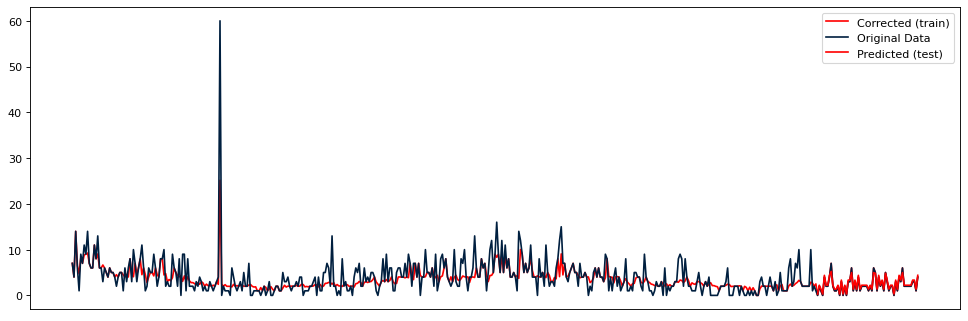

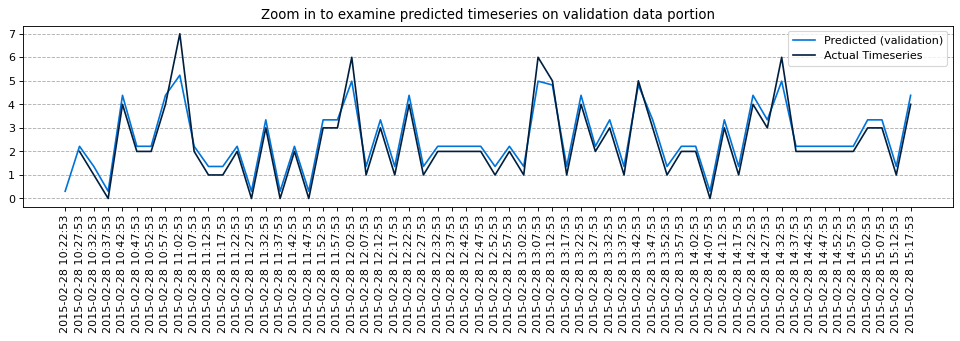

cLSTM RMSE --  0.43897822008515075


In [51]:
def run_epoch(dataloader, LSTM = False,  model_sarima=None, is_training=False, epoch_ready=False , pre_epoch=False, pre_pre_epoch=False, detect_error=  np.array([]), auto_arima = use_auto_arima):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()
        
    original_signal = np.array([])
    corrected_signal = np.array([])
    y_corrected_signal = np.array([])    
    return_model = False
    historycorrectorlstm_archive = []
    
    for idx, (x, y) in enumerate(dataloader):
        
        if is_training:
            optimizer.zero_grad()
            batchsize = x.shape[0]
            
            if pre_epoch and idx < (len(dataloader)-1):
                #print("Pre epoch - ID: ", idx)    
                torch.save(model.state_dict(), PATH) 
                x = x.to(config["training"]["device"])
                y = y.to(config["training"]["device"])
                out, historycorrectorlstm, historycorrection = model(x, model_sarima, pre_epoch=True , detection_threshold = detection_threshold)
                
            elif pre_epoch and idx == (len(dataloader)-1):                
                
                #print("Pre epoch - ID: ", idx)  
                torch.save(model.state_dict(), PATH)                
                x = x.to(config["training"]["device"])
                y = y.to(config["training"]["device"])
                
                out, historycorrectorlstm, historycorrectorlstm_archive, historycorrection, model_sarima, detect_error = model(x, model_sarima, pre_epoch=True, run_detection=True, auto_arima = auto_arima, detection_threshold = detection_threshold)
            
            elif epoch_ready:
                
                #print("Epoch ready - ID: ", idx)
                original_signal = np.concatenate((original_signal, x[0][0]))
                #print("Raw time series value: ", x[0][0][0])      
                
                torch.save(model.state_dict(), PATH) 
                
                x = x.to(config["training"]["device"])
                y = y.to(config["training"]["device"])
                
                out, historycorrectorlstm, historycorrection = model(x, model_sarima, epoch_ready, detection_threshold = detection_threshold)
                initial_distance = historycorrection[-1][0]
                initial_value = x[0][0][0]
                #print("Initial value:", initial_value)
                
                past_distances = []
                past_signs = []
                past_distances.append(initial_distance)               
                
                idsarima = 0                          
                past_signs.append(-1)
                verified = 0       
                
                breaker = False
                update_value = 0.1
                
                if idx < 3:
                    corrected_signal = np.concatenate((corrected_signal, x[0][0]))
                    y_corrected_signal = np.concatenate((y_corrected_signal, y))
                
                if idx in detect_error and idx >= 3:
                    while historycorrection[-1][0] > detection_threshold:
                        if breaker:
                            break
                        while historycorrection[-1][0] > correction_threshold:
                            
                            corrected__signal = np.concatenate((corrected_signal, x[0][0]))
                            #plt.plot(corrected__signal, label="Corrected")
                            #plt.plot(original_signal, label="Original")
                            #plt.legend()
                            #plt.show()
                            
                            if idsarima == 0:

                                model.load_state_dict(torch.load(PATH))
                                x = x.to(config["training"]["device"])
                                y = y.to(config["training"]["device"])
                                # Recompute Sarima Orders if it is first time detection
                                out, historycorrectorlstm, historycorrection = model(x, model_sarima, epoch_ready, corrected=True, detection_threshold = detection_threshold)
                                idsarima += 1
                                breaker = False
                                
                            elif idsarima == 1:
                                
                                #print("sign: ", sign)
                                #print(update_value)
                                x[0][0][0] = x[0][0][0] + sign * update_value                      
                                
                                model.load_state_dict(torch.load(PATH))
                                x = x.to(config["training"]["device"])
                                y = y.to(config["training"]["device"])
                
                                out, historycorrectorlstm, historycorrection = model(x, model_sarima, epoch_ready, corrected=True, detection_threshold = detection_threshold)
                                breaker = False
                                
                            else:
                                
                                x[0][0][0] = initial_value
                                #print("Initial value:", x[0][0][0])
                                model.load_state_dict(torch.load(PATH))
                                x = x.to(config["training"]["device"])
                                y = y.to(config["training"]["device"])
                                out, historycorrectorlstm, historycorrection = model(x, model_sarima, epoch_ready, corrected=True, detection_threshold = detection_threshold)
                                breaker = True
                                break
                                
                            #print("Previous distance:", past_distances[-1])
                            # No exceed limits & verify distance                            
                            if historycorrection[-1] is not None:
                                if historycorrection[-1][0] > past_distances[-1]:
                                    sign = past_signs[-1] * -1
                                else:
                                    sign = past_signs[-1] * 1

                                if (past_distances.count(historycorrection[-1][0]) > 1):
                                    update_value = 0.01
                                    #print("Reduce value of change")
                                if (past_distances.count(historycorrection[-1][0]) > 2):
                                    idsarima = 2
                                    #print("Early Stop Excuted")
                                    
                                past_signs.append(sign)
                                past_distances.append(historycorrection[-1][0])
                                
                                #print("Data id:",idx," distance: ", historycorrection[-1][0])   
                                #print("New value: ", x[0][0][0])
                            
                            else:
                                corrected = True
                                break
                if idx >= 3:
                    corrected_signal = np.concatenate((corrected_signal, x[0][0]))
                    y_corrected_signal = np.concatenate((y_corrected_signal, y)) 
            else:  
                x = x.to(config["training"]["device"])
                y = y.to(config["training"]["device"])
                if LSTM:
                    out = model(x) 
                else:
                    out, historycorrectorlstm, historycorrection = model(x)
        else:
            optimizer.zero_grad()
            batchsize = x.shape[0]
            
            x = x.to(config["training"]["device"])
            y = y.to(config["training"]["device"])
            
            if LSTM:
                out = model(x) 
            else:
                out, historycorrectorlstm, historycorrection = model(x)
        
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()
        
        epoch_loss += (loss.detach().item() / batchsize)

    lr = scheduler.get_last_lr()[0]
    
    if pre_pre_epoch:
        return epoch_loss, lr, model_sarima
    elif pre_epoch:
        return epoch_loss, lr, model_sarima, detect_error, historycorrectorlstm_archive
    elif epoch_ready and is_training:
        return epoch_loss, lr, historycorrectorlstm, historycorrection, original_signal, corrected_signal, y_corrected_signal, detect_error
    else:
        return epoch_loss, lr    
    
path = './NAB-master/data/'
csv_files = glob.glob(os.path.join(path, "*/*.csv"))
# loop over the list of csv files
time_list = []
res = pd.DataFrame()
for f in csv_files[54:55]:
    clear_output(wait=True)
    for md_type in ['LSTM', 'cLSTM']:
        # read the csv file
        # print the location and filename
        print('Location:', f)
        print('File Name:', f.split("\\")[-1])

        data_set_name = f.split('\\')[1]    
        unique_id = f.split('\\')[2]
        start_time = time.time()

        print("Working on: ",data_set_name," series :", unique_id)
        data_close_price = pd.read_csv(f)["value"].values[:500]
        
        # normalize
        scaler = Normalizer()
        normalized_data_close_price = scaler.fit_transform(data_close_price) 
        normalized_data_close_price_extra = normalized_data_close_price[-round(len(normalized_data_close_price)*(1-config["data"]["train_split_size"])):]
        #normalized_data_close_price = normalized_data_close_price[:-round(len(normalized_data_close_price)*0.12)]

        plt.plot(normalized_data_close_price)
        plt.show()
        if md_type == "cLSTM":
            split_index, data_x_train, data_y_train, data_x_val, data_y_val, data_x_unseen = prepare_data(normalized_data_close_price, config, plot=config["plots"]["show_plots"])

            dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
            dataset_val = TimeSeriesDataset(data_x_val, data_y_val)

            print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
            print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)

            #cLSTM
            model = cLSTMModel(input_size=config["model"]["input_size"], hidden_layer_size=config["model"]["lstm_size"], num_layers=config["model"]["num_lstm_layers"], output_size=1, dropout=config["model"]["dropout"])
            model = model.to(config["training"]["device"])

            PATH = "statedictmode" 
            # create `DataLoader`
            train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=False)
            val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=False)

            # define optimizer, scheduler and loss function
            criterion = nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr=config["training"]["learning_rate"], betas=(0.9, 0.98), eps=1e-9)
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["training"]["scheduler_step_size"], gamma=0.1)
            detect_error = np.array([])
            # begin training
            for epoch in range(config["training"]["num_epoch"]):
                if epoch == 48:
                    loss_train, lr_train, model_sarima, detect_error, historycorrectorlstm_archive = run_epoch(train_dataloader,  model_sarima= None, is_training=True, pre_epoch=True)
                    scheduler.step()
                elif epoch == 49: #round(config["training"]["num_epoch"]/3):
                    loss_train, lr_train, historycorrectorlstm, historycorrection, original_signal, corrected_signal, y_corrected_signal, detect_error = run_epoch(train_dataloader, model_sarima= model_sarima, is_training=True, epoch_ready=True, detect_error=detect_error)
                    scheduler.step()
                elif epoch < 48 :
                    loss_train, lr_train = run_epoch(train_dataloader,  model_sarima= None, is_training=True, epoch_ready=False)
                    scheduler.step()
                else:
                    corrected_timeseries = np.append(corrected_signal, y_corrected_signal[-1])
                    corrected_timeseries = np.append(corrected_timeseries, normalized_data_close_price_extra)            

                    split_index, data_x_train, data_y_train, data_x_val, data_y_val, data_x_unseen = prepare_data(corrected_timeseries, config, plot=config["plots"]["show_plots"])
                    dataset_train = TimeSeriesDataset(data_x_train, data_y_train)            
                    train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=False)

                    loss_train, lr_train = run_epoch(train_dataloader, None, is_training=True, epoch_ready=False)
                    scheduler.step()

                print('Epoch[{}/{}] | loss train:{:.6f} | lr:{:.6f}'
                          .format(epoch+1, config["training"]["num_epoch"], loss_train, lr_train))

            time_list.append([unique_id, (time.time() - start_time)])

            # here we re-initialize dataloader so the data doesn't shuffled, so we can plot the values by date
            torch.manual_seed(0)    

            model.eval()
            # predict on the training data, to see how well the model managed to learn and memorize

            predicted_train = np.array([])
            for idx, (x, y) in enumerate(train_dataloader):
                x = x.to(config["training"]["device"])
                out = model(x)
                out = out[0].cpu().detach().numpy()
                predicted_train = np.concatenate((predicted_train, out))

            # predict on the validation data, to see how the model does

            predicted_val = np.array([])

            for idx, (x, y) in enumerate(val_dataloader):
                x = x.to(config["training"]["device"])
                out = model(x)
                out = out[0].cpu().detach().numpy()
                predicted_val = np.concatenate((predicted_val, out))

            if True:
                # prepare data for plotting, show predicted prices
                # prepare data for plotting, show predicted prices
                data_date = np.array(pd.read_csv(f)["timestamp"].values[:500])

                num_data_points = len(data_date)

                to_plot_data_y_train_pred = np.zeros(num_data_points)
                to_plot_data_y_val_pred = np.zeros(num_data_points)

                to_plot_data_y_train_pred[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(predicted_train)
                to_plot_data_y_val_pred[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(predicted_val)

                to_plot_data_y_train_pred = np.where(to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred)
                to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)

                # plots

                fig = figure(figsize=(15, 5), dpi=80)
                fig.patch.set_facecolor((1.0, 1.0, 1.0))
                #plt.plot(data_date, to_plot_data_y_train_pred, label="Predicted (train)", color=config["plots"]["color_pred_train"])
                plt.plot(data_date[1:], scaler.inverse_transform(corrected_timeseries)[:-1], label="Corrected (train)", color="red")
                plt.plot(data_date[1:], data_close_price[:-1], label="Original Data", color=config["plots"]["color_actual"])
                plt.plot(data_date, to_plot_data_y_val_pred, label="Predicted (test)", color="red")
                plt.xticks([])
                plt.legend()
                plt.show()

                # prepare data for plotting, zoom in validation
                to_plot_data_y_val_subset = scaler.inverse_transform(data_y_val)
                to_plot_predicted_val = scaler.inverse_transform(predicted_val)
                to_plot_data_date = data_date[split_index+config["data"]["window_size"]:]

                # plots
                fig = figure(figsize=(15, 3), dpi=80)
                fig.patch.set_facecolor((1.0, 1.0, 1.0))
                plt.plot(to_plot_data_date, to_plot_predicted_val, label="Predicted (validation)", color=config["plots"]["color_pred_val"])
                plt.plot(to_plot_data_date[1:], to_plot_data_y_val_subset[:-1], label="Actual Timeseries", color=config["plots"]["color_actual"])
                plt.title("Zoom in to examine predicted timeseries on validation data portion")
                plt.grid(b=None, which='major', axis='y', linestyle='--')
                plt.xticks(rotation='vertical')
                plt.legend()
                plt.show() 

                rmse = np.sqrt(mean_squared_error(to_plot_data_y_val_subset[:len(to_plot_data_y_val_subset)-1], to_plot_predicted_val[1:]))
                print("cLSTM RMSE -- ", rmse)
        
        elif md_type=="LSTM":
            split_index, data_x_train, data_y_train, data_x_val, data_y_val, data_x_unseen = prepare_data(normalized_data_close_price, config, plot=config["plots"]["show_plots"])

            dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
            dataset_val = TimeSeriesDataset(data_x_val, data_y_val)

            print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
            print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)

            model = LSTMModel(input_size=config["model"]["input_size"], hidden_layer_size=config["model"]["lstm_size"], num_layers=config["model"]["num_lstm_layers"], output_size=1, dropout=config["model"]["dropout"])
            model = model.to(config["training"]["device"])

            # create `DataLoader`
            train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=False)
            val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=False)

            # define optimizer, scheduler and loss function
            criterion = nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr=config["training"]["learning_rate"], betas=(0.9, 0.98), eps=1e-9)
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["training"]["scheduler_step_size"], gamma=0.1)

            # begin training
            for epoch in range(config["training"]["num_epoch"]):
                loss_train, lr_train = run_epoch(train_dataloader, is_training=True, LSTM = True)
                loss_val, lr_val = run_epoch(val_dataloader, LSTM = True)
                scheduler.step()

                print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
                          .format(epoch+1, config["training"]["num_epoch"], loss_train, loss_val, lr_train))

            # here we re-initialize dataloader so the data doesn't shuffled, so we can plot the values by date
            torch.manual_seed(0)
            train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=False)
            val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=False)

            model.eval()

            # predict on the training data, to see how well the model managed to learn and memorize

            predicted_train = np.array([])

            for idx, (x, y) in enumerate(train_dataloader):
                x = x.to(config["training"]["device"])
                out = model(x)
                out = out.cpu().detach().numpy()
                predicted_train = np.concatenate((predicted_train, out))

            # predict on the validation data, to see how the model does

            predicted_val = np.array([])

            for idx, (x, y) in enumerate(val_dataloader):
                x = x.to(config["training"]["device"])
                out = model(x)
                out = out.cpu().detach().numpy()
                predicted_val = np.concatenate((predicted_val, out))

            if True:
                # prepare data for plotting, show predicted prices
                # prepare data for plotting, show predicted prices
                data_date = np.array(pd.read_csv(f)["timestamp"].values[:500])

                num_data_points = len(data_date)

                to_plot_data_y_train_pred = np.zeros(num_data_points)
                to_plot_data_y_val_pred = np.zeros(num_data_points)

                to_plot_data_y_train_pred[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(predicted_train)
                to_plot_data_y_val_pred[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(predicted_val)

                to_plot_data_y_train_pred = np.where(to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred)
                to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)

                # plots

                fig = figure(figsize=(15, 5), dpi=80)
                fig.patch.set_facecolor((1.0, 1.0, 1.0))
                plt.plot(data_date, to_plot_data_y_train_pred, label="Predicted (train)", color=config["plots"]["color_pred_train"])
                plt.plot(data_date[1:], data_close_price[:-1], label="Original Data", color=config["plots"]["color_actual"])
                plt.plot(data_date, to_plot_data_y_val_pred, label="Predicted (test)", color="red")
                plt.xticks([])
                plt.legend()
                plt.show()

                # prepare data for plotting, zoom in validation
                to_plot_data_y_val_subset = scaler.inverse_transform(data_y_val)
                to_plot_predicted_val = scaler.inverse_transform(predicted_val)
                to_plot_data_date = data_date[split_index+config["data"]["window_size"]:]

                # plots
                fig = figure(figsize=(15, 3), dpi=80)
                fig.patch.set_facecolor((1.0, 1.0, 1.0))
                plt.plot(to_plot_data_date, to_plot_predicted_val, label="Predicted (validation)", color=config["plots"]["color_pred_val"])
                plt.plot(to_plot_data_date[1:], to_plot_data_y_val_subset[:-1], label="Actual Timeseries", color=config["plots"]["color_actual"])
                plt.title("Zoom in to examine predicted timeseries on validation data portion")
                plt.grid(b=None, which='major', axis='y', linestyle='--')
                plt.xticks(rotation='vertical')
                plt.legend()
                plt.show() 

                rmse = np.sqrt(mean_squared_error(to_plot_data_y_val_subset[:len(to_plot_data_y_val_subset)-1], to_plot_predicted_val[1:]))
                print("LSTM RMSE -- ", rmse)